# Projet P4 - Anticipez les besoins en consommation de bâtiments
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 12/2023*
<hr>

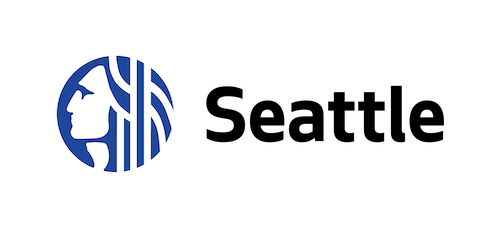

# <font color='#0a389f'>Introduction<a class="anchor" id="Presentation_projet"></a></font>

Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, l'objectif est de tenter de **prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

La prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...). 

L'intérêt de la variable "ENERGY STAR Score" pour la prédiction des émissions CO2 et de la consommation totale d'énergie sera également à évaluer.

Le projet se décompose en 3 notebooks :
1. Analyse exploratoire
2. Prédiction de la consommation totale d'énergie
3. Prédiction des émissions de CO2

Le présent notebook porte sur l'analyse exploratoire.

## <font color='#46abe6'>Sommaire</font>

<span style='background:#d5155b'><span style='color:white'>**Notebook 1 - Analyse exploratoire**</span></span>

[Partie 1 - Importation et Inspection des données](#partie_1)
* [1.1. Importation des librairies](#1_1)
* [1.2. Définition des fonctions](#1_2)
* [1.3. Importation et inspection des données](#1_3)

[Partie 2 - Inspection et sélection des variables pertinentes](#partie_2)
* [2.1. Filtre sur les bâtiments non résidentiels : BuildingType](#2_1)
* [2.2. Filtre sur la qualité des données : ComplianceStatus, DefaultData & Outlier](#2_2)
* [2.3. Variables cibles pour émissions carbone et consommation totale d'énergie et autres variables énergie](#2_3)
* [2.4. Variables de situation géographique](#2_4)
* [2.5. Variables utilisation et structure du bâtiment](#2_5)
* [2.6. Conclusion - Variables sélectionnées](#2_6)

[Partie 3 - Identification et traitement des valeurs aberrantes](#partie_3)
* [3.1. Description des variables quantitatives](#3_1)
* [3.2. Identification des valeurs aberrantes avec la méthode du Z-Score](#3_2)
* [3.3. Analyse et traitement des valeurs aberrantes](#3_3)

[Partie 4 - Analyse exloratoire](#partie_4)
* [4.1. Ajout de nouvelles variables](#4_1)
* [4.2. Distributions des variables](#4_2)
* [4.3. Transformation des variables](#4_3)
* [4.4. Distribution par 'Neighborhood' et par 'PrimaryPropertyType'](#4_4)
* [4.5. Corrélation entre les variables](#4_5)
* [4.6. Sauvegarde des datasets pour la modélisation](#4_6)
* [4.7 Change log](#4_7)

[Conclusion & Perspectives](#partie_5)

<span style='background:#46abe6'><span style='color:white'>**Notebook 2 - Prédiction de la consommation totale d'énergie**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Notebook 3 - Prédiction des émissions CO2**</span></span>

# <font color='#0a389f'>Partie 1 - Importation et Inspection des données<a class="anchor" id="partie_1"></a></font>

## <font color='#46abe6'>1.1. Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

# graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# représentation graphiques des valeurs manquantes
import missingno as msno 

from skimpy import skim # inspection des dataframes

from IPython.display import Markdown # affichage Markdown des Outputs

# carte
import folium
import geopandas as gpd

# Expression régulière
import re

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.26.4
pandas - 2.1.1
seaborn - 0.13.0
missingno - 0.5.2
folium - 0.15.1
geopandas - 0.14.2
re - 2.2.1


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

In [4]:
# Options d'affichage : toutes les colonnes
pd.set_option('display.max_columns', None)

## <font color='#46abe6'>1.2. Définition des fonctions<a class="anchor" id="1_2"></a></font>

### Inspection du dataframe

In [5]:
# Fonction pour inspection df
def inspection(df, dfname):
    """!
    @brief Effectue une inspection approfondie du dataframe.

    Cette fonction affiche les premières lignes, les dimensions, les types de variables, 
    les valeurs manquantes, supprime les colonnes vides et avec une seule modalité, identifie les doublons,
    présente une description statistique du dataframe et un échantillon des modalités des variables qualitatives.

    @param df: Dataframe à inspecter (pandas DataFrame).
    @param dfname: Nom du dataframe (str).
    """
    
    # Options d'affichage : toutes les lignes
    pd.set_option('display.max_rows', None)
    
    print("*" * 50)
    print(f"Inspection du dataframe {dfname}")
    print("*" * 50)
    print("")
    
    # Affichage des premières lignes du dataframe
    print("Dataframe")
    print("-" * 50)
    display(df.head())
    print("")
    
    # Supression des colonnes vides ou avec une unique modalité et sans valeurs manquantes
    del_col(df)

    # Affichage des dimensions, types de variables et valeurs non-null, 
    # Description statistique du dataframe (moyenne, écart-type, min-max, médiane, IQR)
    print("Dimensions du dataframe, Types de variables, Description statistique du dataframe, Valeurs non-null")
    print("-" * 50)
    print(skim(df))
    print("")
          
    # Affichage des valeurs uniques par colonne
    print("Valeurs uniques par variable")
    print("-" * 50)   
    print(df.nunique())
    print("")
    
    # Identification et affichage des doublons
    print("Nombre de doublons")
    print("-" * 50)   
    print(df.duplicated().sum())
    print("")
    
    # Affichage d'un échantillon des modalités des variables qualitatives (si applicable)
    col = df.select_dtypes(include='object').columns.tolist()
    
    if len(col)>0:
        print("")
        print("Echantillon des modalités des variables qualitatives (5 modalités max)")
        print("-" * 50) 
        for c in col:
            print(f'{c} : {df[c].unique()[:5]}\n')   
            
    # Affichage du graphique des valeurs manquantes (si applicable)
    if sum(df.isna().sum()) > 0:
        print("")
        print("Graphique des valeurs manquantes")
        print("-" * 50)    
        msno.bar(df)
        msno.matrix(df)
    

  
    # Réinitialiser l'option pour revenir aux paramètres par défaut
    pd.reset_option('display.max_rows')

In [6]:
def del_col(df):
    """!
    @brief Supprime les colonnes du DataFrame selon certains critères.

    Cette fonction supprime les colonnes vides (contenant uniquement des valeurs NaN), ainsi que les colonnes 
    qui ne contiennent aucune valeur manquante et qui n'ont qu'une seule modalité.

    @param df : Le DataFrame à nettoyer. (type: pandas.DataFrame)
    """    
    mean_na = df.isna().mean()
    nunique = df.nunique()

    # Suppression des colonnes vides le cas échéant
    if max(mean_na) == 1:
        print("")
        print("Suppression des colonnes vides")
        print("-" * 50) 
        print('Dimensions du dataframe avant suppression :', df.shape)
        col_null = list(mean_na[mean_na == 1].index)
        print('Colonne(s) supprimée(s) :', col_null)
        df.drop(columns=col_null, inplace=True)
        print('Dimensions du dataframe après suppression :', df.shape)
        print("")
 
    # Suppression des colonnes sans valeurs manquantes et avec une seule modalité
    onemodal = pd.DataFrame({'mean_na' : mean_na,
                             'nunique' : nunique})
    onemodal = onemodal[(onemodal['mean_na'] == 0) & (onemodal['nunique'] == 1)]
    
    if onemodal.shape[0] >0:
        print("")
        print("Suppression des colonnes sans valeurs manquantes et avec une seule modalité")
        print("-" * 50) 
        print('Dimensions du dataframe avant suppression :', df.shape)
              
        onemodal = onemodal[(onemodal['mean_na'] == 0) & (onemodal['nunique'] == 1)]
        col_to_drop = list(onemodal.index)
        
        print('Colonne(s) supprimée(s) et modalités:')
        for c in col_to_drop:
            print(f'{c} = {df[c].unique()}')
        
        df.drop(columns=col_to_drop, inplace=True)
        print('Dimensions du dataframe après suppression :', df.shape)
        print("")

In [7]:
def definition(feature):
    """!
    @brief Affiche la définition d'une variable donnée à partir d'un dictionnaire de données.

    @param feature : Le nom de la fonctionnalité dont on souhaite afficher la définition (type string)
    """
    # Affiche la définition de feature
    display(Markdown(f'**{feature}** : {data_dict[feature]["definition"]}'))

### Suivi des modifications

In [8]:
def change_log(change_log_df, df, change_list):
    """!
    @brief: Met à jour un dataframe listant les modifications apportées

    Cette fonction ajoute une ligne au dataframe change_log_df décrivant les modifications apportées à df

    @param change_log_df : Dataframe listant les modifications (type pd.DataFrame)
    @param df : Dataframe qui a été modifié (type pd.DataFrame)
    @param change_list : Liste avec [type de mofication, sur quelle variable, description de la modification] (type list)
    """
    # Nouvelle ligne : dimensions du dataframe, type de change, sur quelle variable, description du change
    new_row = [
               df.shape[0],
               df.shape[1],
               change_list[0],
               change_list[1],
               change_list[2]
               ]
    
    # ajoute la nouvelle ligne à la fin de change_log_df
    change_log_df.loc[len(change_log_df)] = new_row

### Imputation des valeurs manquantes

In [9]:
def map_subcat_to_cat(subcat, categories_dict):
    """!
    @brief Mappe une sous-catégorie à sa catégorie correspondante.

    Cette fonction prend une sous-catégorie et un dictionnaire de correspondances entre
    catégories et sous-catégories. Elle renvoie la catégorie correspondante à la
    sous-catégorie donnée. 

    @param subcat: Sous-catégorie à mapper (type string).
    @param categories_dict: Dictionnaire de correspondances entre catégories et sous-catégories (type dict).
    @return: Catégorie correspondante à la sous-catégorie (type string ou None si aucune correspondance).
    """

    # Recherche de la catégorie correspondante à la sous-catégorie
    original_category = None
    for cat, subcats in categories_dict.items():
        if subcat in subcats:
            original_category = cat

    return original_category

### Valeurs aberrantes

In [10]:
def detectOutlier(data, threshold):
    """!
    @brief Détecte les outliers dans une série de données en utilisant la méthode du z-score.

    Cette fonction identifie les valeurs aberrantes (outliers) dans une série de données en comparant
    les valeurs individuelles à la moyenne et à l'écart-type. Les valeurs au-dessus du seuil spécifié
    sont considérées comme des outliers.

    @param data: Série de données à analyser pour la détection des outliers (type pandas Series ou liste).
    @param threshold: Seuil au-dessus duquel le z-score est considéré comme outlier (type float, valeur recommandée : [2, 3]).
    @return outliers: Liste des outliers de la variable (type list).
    """
    outliers = []  # Crée une liste vide pour stocker les outliers
    mean = np.mean(data)  # Calcul de la moyenne des données
    std = np.std(data)  # Calcul de l'écart-type des données
    
    for i in data:
        if std == 0:
            print('Écart-type nul')
            break
        z_score = (i - mean) / std  # Calcul du z-score pour la valeur i
        if np.abs(z_score) > threshold:  # Valeur absolue du z-score
            outliers.append(i)  # Ajoute i à la liste des outliers
            
    return outliers

In [11]:
def print_outlier(df, columns, res_var):
    """!
    @brief: Identifie les outliers pour chaque indicateur et les affiche dans le dataframe de sortie.
         
    @param df : Le dataframe contenant les données à analyser (type pandas.DataFrame).
    @param columns : Liste des noms de colonnes à analyser (type list).
    @param res_var : Liste des variables à afficher pour le nom de colonne dans le dataframe de sortie (type list).
    """
    for col in columns:
        # Application de la fonction à la série subset
        subset = df[col]
        outliers = detectOutlier(subset,2)
        
        # Variables à afficher
        if col in res_var:
            var = res_var
        else:
            var = res_var + [col]
        
        # Extract du dataframe
        res=df.loc[df[col].isin(outliers),var].sort_values(col, ascending=False)
        
        # Affichage des outliers détectés
        print("")
        display(Markdown(f"- **{col}** : Nombre d'outliers détectés => " + str(len(outliers))))
        
        # Si le nombre d'outliers est >0, afficher le dataframe res
        if len(outliers)>0:
            # s'il y a plus de 10 outliers, afficher un extrait de res
            if len(outliers)>=10:
                print("5 premiers outliers : ")
                display(res.head(5))      
                print("5 derniers outliers : ")
                display(res.tail(5)) 
            else:
                display(res)

In [12]:
def stats(df, indicator, var, colors, showfliers):
    """!
    @brief Affiche pour chaque indicateur un boxplot par modalité de la variable.

    Cette fonction affiche un boxplot pour chaque indicateur, regroupé par modalité de la variable spécifiée. 

    @param df: Dataframe contenant les données (pandas DataFrame).
    @param indicator: Liste contenant les noms des indicateurs à analyser (list de string).
    @param var: Variable utilisée pour le regroupement (string).
    @param colors: Liste des couleurs à utiliser pour le graphique (list de string).
    @param showfliers: True or False, pour l'affichage des outliers (type booléen).
    """

    # Boucle pour afficher pour chaque indicateur : un boxplot par var
    for ind in indicator:

        # Création et affichage du boxplot
        ax = sns.boxplot(data=df.sort_values(var), 
                    x=ind, 
                    y=var, 
                    hue=var, 
                    showfliers=showfliers, 
                    showmeans=True, 
                    meanprops=meanprops,
                    palette=colors,
                    legend=False)
        
        
        # Ajout des valeurs de value_counts pour var sur les étiquettes en y
        value_counts = df[var].value_counts().sort_index()
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels([f'{label} ({count})' for label, count in value_counts.items()])
        
        plt.title(f"{ind} : Distribution par {var} (nb occurrences)", wrap=True)
        plt.show()

## <font color='#46abe6'>1.3. Importation et inspection des données<a class="anchor" id="1_3"></a></font>

In [13]:
# Dictionnaire avec le nom de la variable, sa définition et son type
data_dict = pd.read_csv('dict.csv', sep=';', index_col='feature')
data_dict = data_dict.to_dict(orient='index')

In [14]:
# Importation des données
building_rawdata=pd.read_csv('2016_Building_Energy_Benchmarking.csv', sep=',')

**************************************************
Inspection du dataframe Building Energy Benchmarking
**************************************************

Dataframe
--------------------------------------------------


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2



Suppression des colonnes vides
--------------------------------------------------
Dimensions du dataframe avant suppression : (3376, 46)
Colonne(s) supprimée(s) : ['Comments']
Dimensions du dataframe après suppression : (3376, 45)


Suppression des colonnes sans valeurs manquantes et avec une seule modalité
--------------------------------------------------
Dimensions du dataframe avant suppression : (3376, 45)
Colonne(s) supprimée(s) et modalités:
DataYear = [2016]
City = ['Seattle']
State = ['WA']
Dimensions du dataframe après suppression : (3376, 42)

Dimensions du dataframe, Types de variables, Description statistique du dataframe, Valeurs non-null
--------------------------------------------------


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3376   │ │ float64     │ 21    │                                                          │
│ │ Number of columns │ 42     │ │ string      │ 13    │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 7     │                                                          │
│                                │ bool        │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃      ┃       ┃         ┃          ┃         ┃        ┃         ┃         ┃           ┃        ┃  │
│ ┃ e          ┃ NA   ┃ NA %  ┃ mean    ┃ sd       ┃ p0      ┃ p25    ┃ p50     ┃ p75     ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ OSEBuildin │    0 │     0 │   21000 │    12000 │       1 │  20000 │   23000 │   26000 │     50000 │ ▃ ▇▅ ▁ │  │
│ │ gID        │      │       │         │          │         │        │         │         │           │        │  │
│ │ ZipCode    │   16 │  0.47 │   98000 │       19 │   98000 │  98000 │   98000 │   98000 │     98000 │    ▇   │  │
│ │ CouncilDis │    0 │     0 │     4.4 │      2.1 │       1 │      3 │       4 │       7 │         7 │ ▂▃▃▂▂▇ │  │
│ │ trictCode  │      │       │         │          │         │        │         │         │           │        │  │
│ │ Latitude   │    0 │     0 │      48 │    0.048 │      47 │     48 │      48 │      48 │        48 │ ▁▃▇▇▅▃ │  │
│ │ Longitude  │    0 │     0 │    -120 │    0.027 │    -120 │   -120 │    -120 │    -120 │      -120 │ ▁▃▇▃▁  │  │
│ │ YearBuilt  │    0 │     0 │    2000 │       33 │    1900 │   1900 │    2000 │    2000 │      2000 │ ▃▃▂▆▇▇ │  │
│ │ NumberofBu │    8 │  0.24 │     1.1 │      2.1 │       0 │      1 │       1 │       1 │       110 │   ▇    │  │
│ │ ildings    │      │       │         │          │         │        │         │         │           │        │  │
│ │ NumberofFl │    0 │     0 │     4.7 │      5.5 │       0 │      2 │       4 │       5 │        99 │   ▇    │  │
│ │ oors       │      │       │         │          │         │        │         │         │           │        │  │
│ │ PropertyGF │    0 │     0 │   95000 │   220000 │   11000 │  28000 │   44000 │   91000 │   9300000 │   ▇    │  │
│ │ ATotal     │      │       │         │          │         │        │         │         │           │        │  │
│ │ PropertyGF │    0 │     0 │    8000 │    32000 │       0 │      0 │       0 │       0 │    510000 │   ▇    │  │
│ │ AParking   │      │       │         │          │         │        │         │         │           │        │  │
│ │ PropertyGF │    0 │     0 │   87000 │   210000 │    3600 │  28000 │   43000 │   84000 │   9300000 │   ▇    │  │
│ │ ABuilding( │      │       │         │          │         │        │         │         │           │        │  │
│ │ s)         │      │       │         │          │         │        │         │         │           │        │  │
│ │ LargestPro │   20 │  0.59 │   79000 │   200000 │    

None

Valeurs uniques par variable
--------------------------------------------------
OSEBuildingID                      3376
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352
ThirdLargestPropertyUseType       

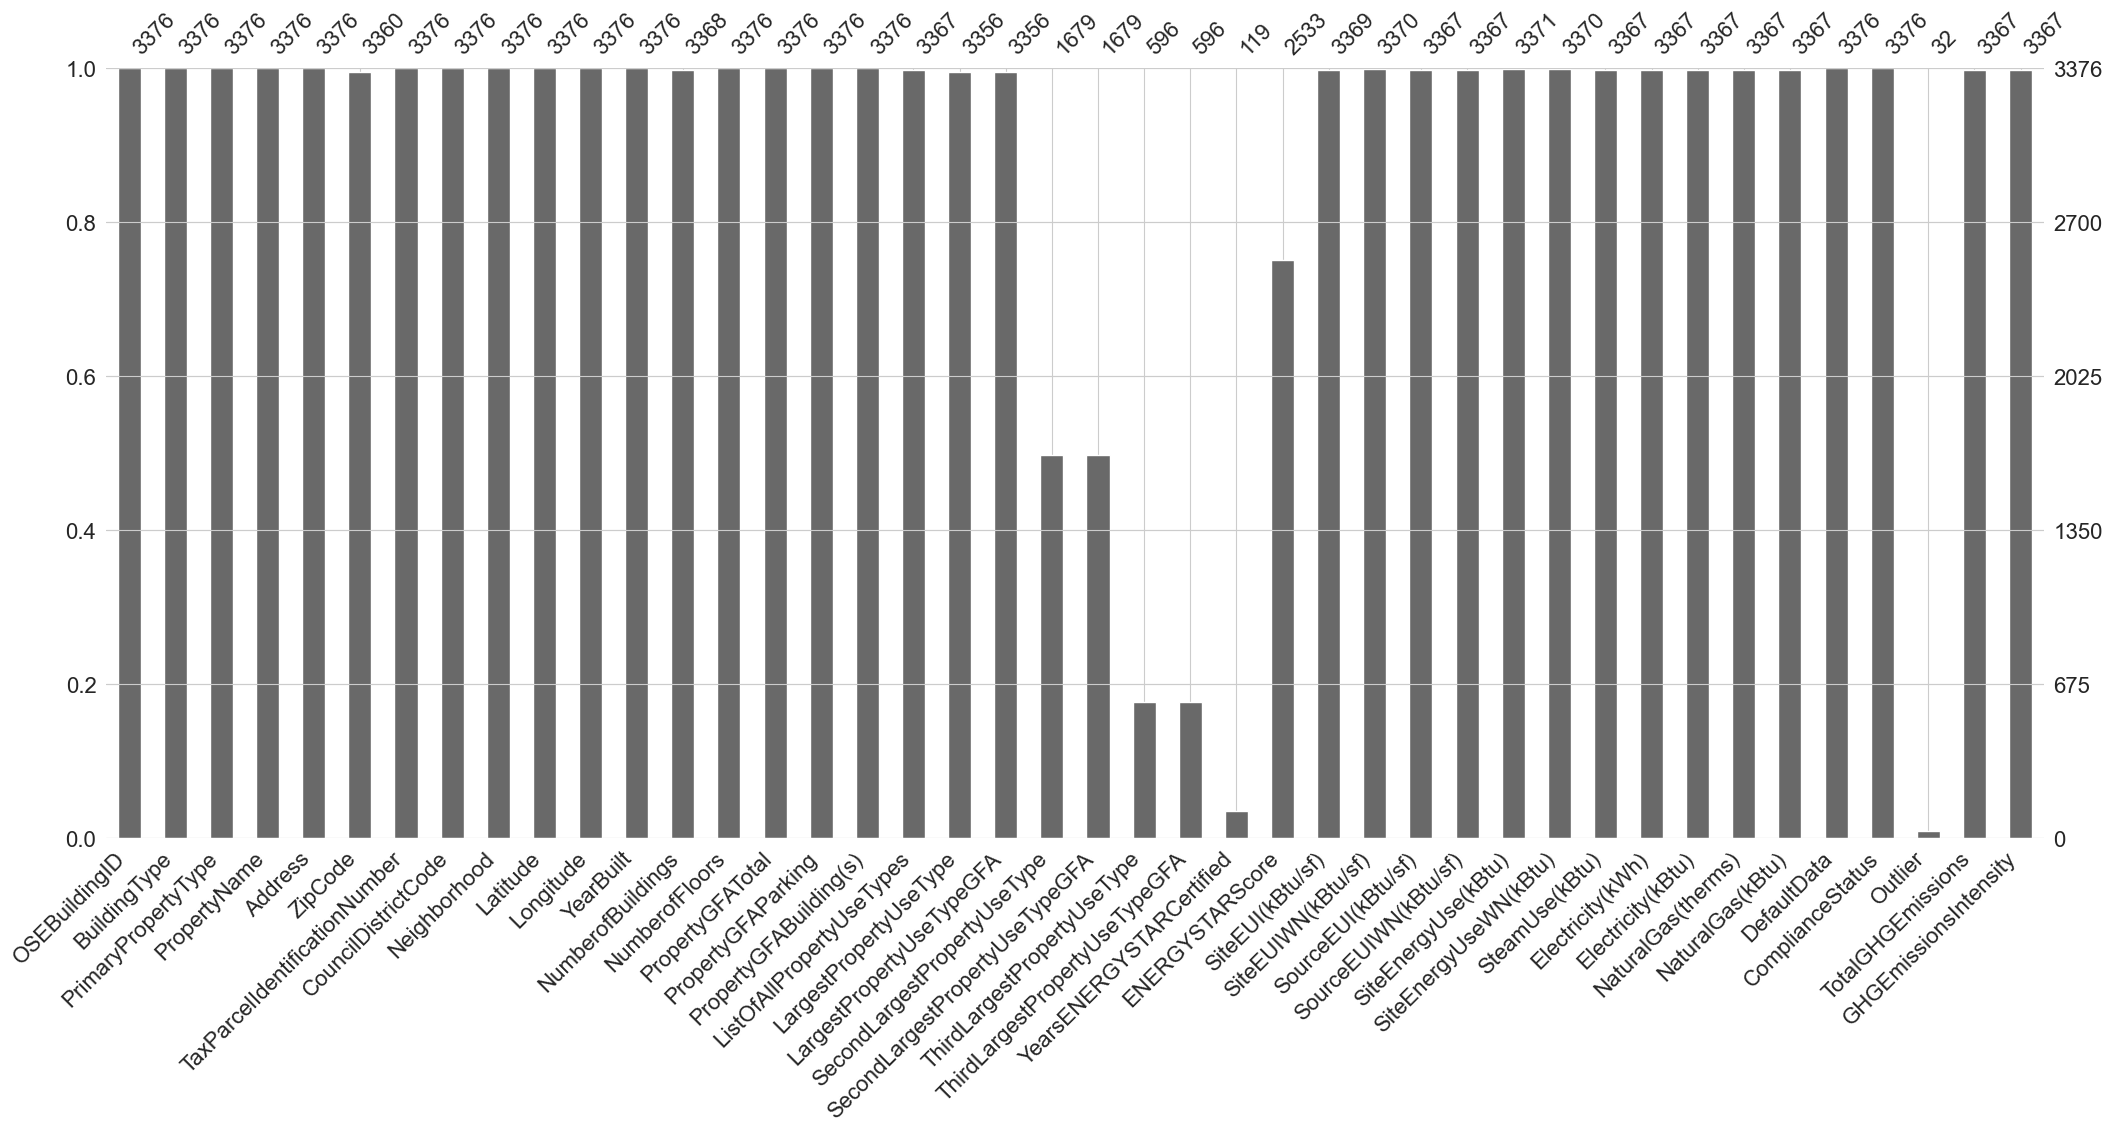

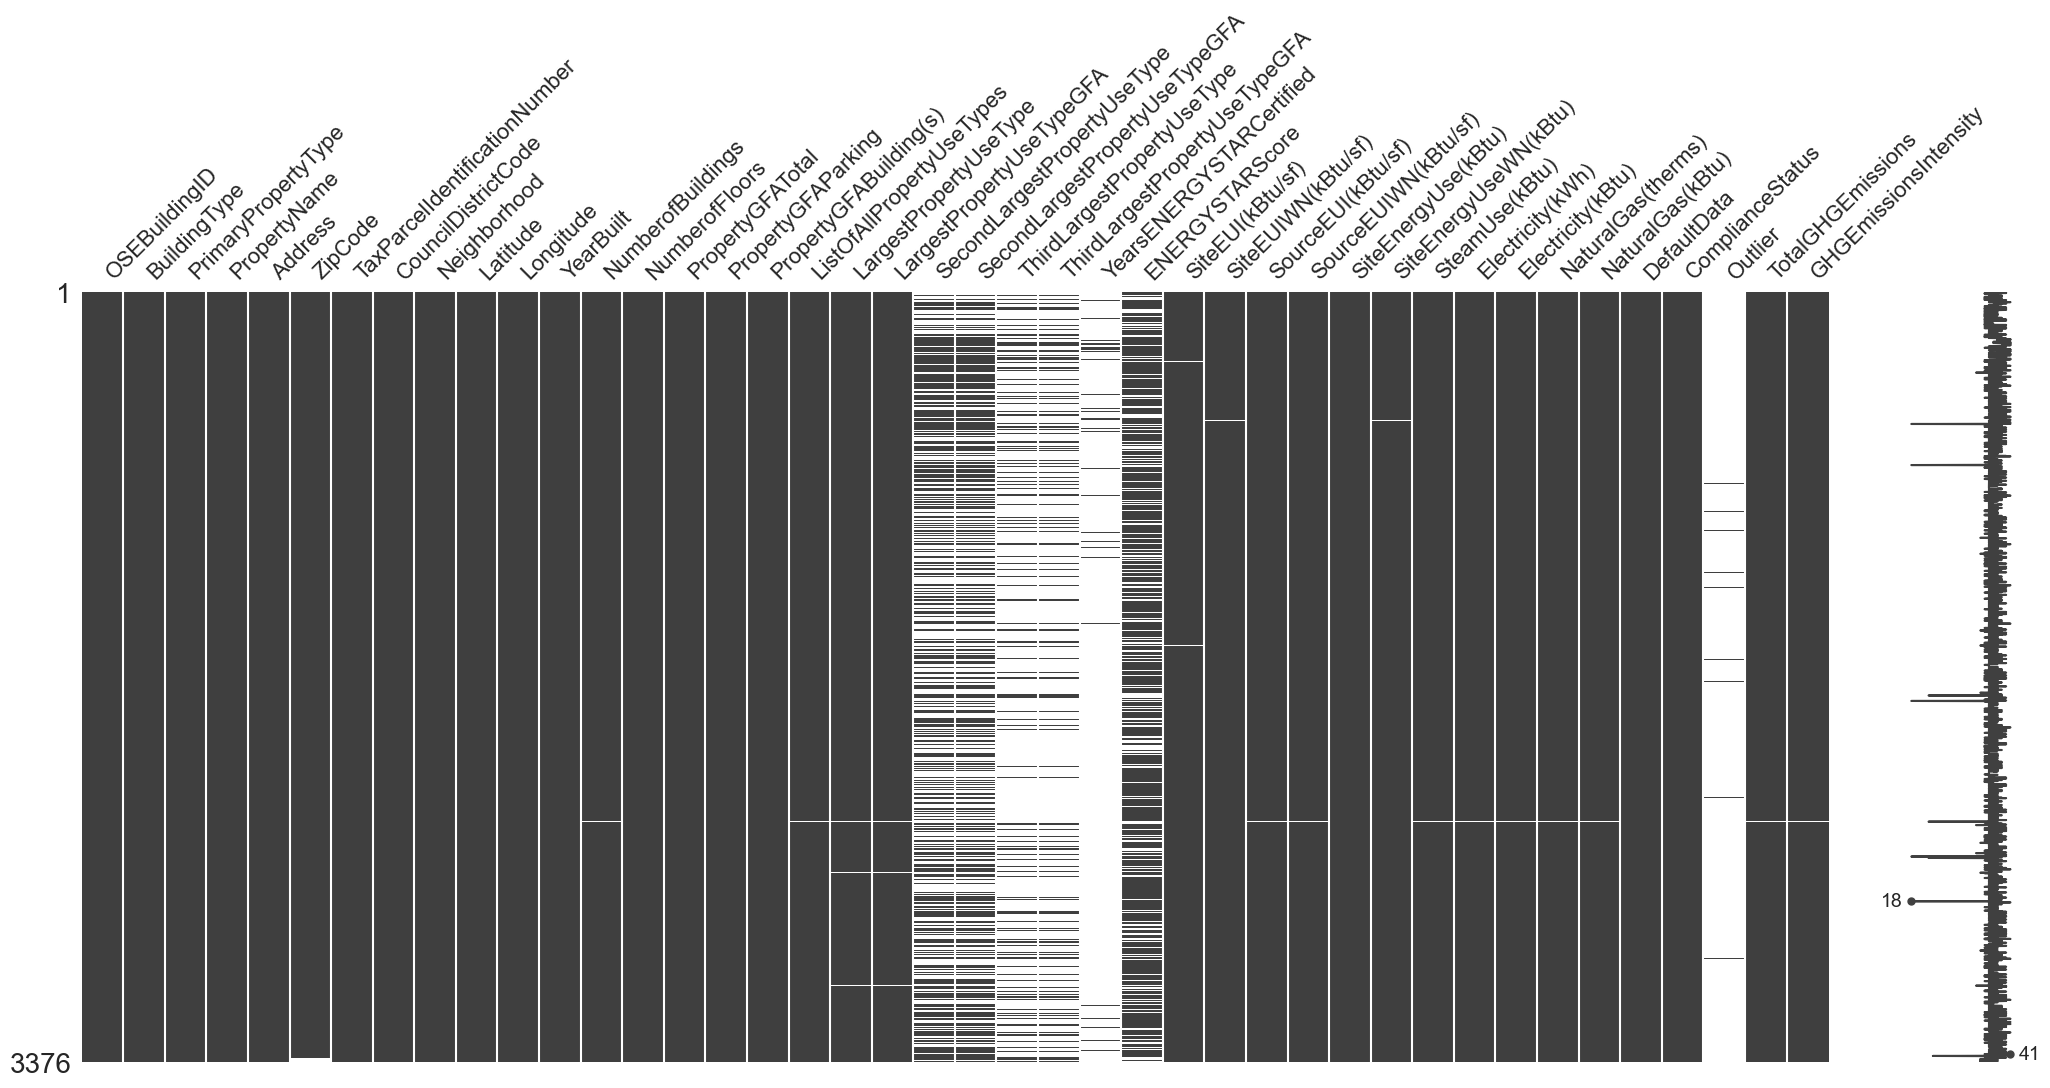

In [15]:
# Inspection du data frame
inspection(building_rawdata, "Building Energy Benchmarking")

- **OSEBuildingID : identifiant unique -> clé primaire** 

In [16]:
# Doublons sur la clé primaire ?
display(Markdown(f"{building_rawdata['OSEBuildingID'].duplicated().sum()} doublon(s) sur la clé primaire `OSEBuildingID`"))

0 doublon(s) sur la clé primaire `OSEBuildingID`

# <font color='#0a389f'>Partie 2 - Inspection et sélection des variables pertinentes<a class="anchor" id="partie2"></a></font>

In [17]:
# Initialisation du dataframe change_log_df
change_log_df = pd.DataFrame({'nb_rows': [building_rawdata.shape[0]],
                              'nb_columns': [building_rawdata.shape[1]],
                              'change_type': ['Etat initial'],
                              'on': ['-'],
                              'description': ['Etat initial du dataframe'],
                              })

## <font color='#46abe6'>2.1. Filtre sur les bâtiments non résidentiels : BuildingType<a class="anchor" id="2_1"></a></font>

In [18]:
# Définition de la variable
display(Markdown(f' **BuildingType** : {data_dict["BuildingType"]["definition"]}'))

 **BuildingType** : City of Seattle building type classification.

In [19]:
# Cible = les bâtiments non destinés à l'habitation
building_data = building_rawdata[building_rawdata['BuildingType'].str.contains('NonResidential', case=False)]
BuildingType = list(building_data['BuildingType'].unique())
print(BuildingType)

['NonResidential', 'Nonresidential COS', 'Nonresidential WA']


*COS - change of status*

In [20]:
# Aggrégation par BuildingType et PrimaryPropertyType
pd.DataFrame(building_data.groupby(['BuildingType', 'PrimaryPropertyType'])['OSEBuildingID'].count())

OSEBuildingID
BuildingType       PrimaryPropertyType                       
NonResidential     Distribution Center                     51
                   Hospital                                10
                   Hotel                                   76
                   K-12 School                             39
                   Laboratory                              10
                   Large Office                           168
                   Low-Rise Multifamily                     2
                   Medical Office                          38
                   Mixed Use Property                     102
                   Other                                  185
                   Refrigerated Warehouse                  12
                   Residence Hall                          21
                   Restaurant                              11
                   Retail Store                            91
                   Self-Storage Facility                   28
                   Senior Care Community                   20
                   Small- and Mid-Sized Office            288
                   Supermarket / Grocery Store             40
                   University                              17
                   Warehouse                              180
                   Worship Facility                        71
Nonresidential COS Distribution Center                      2
                   Large Office                             4
                   Medical Office                           1
                   Mixed Use Property                       8
                   Office                                   3
                   Other                                   56
                   Small- and Mid-Sized Office              4
                   Warehouse                                7
Nonresidential WA  University                               1

=> La variable 'BuildingType' n'est plus pertinente pour la suite.

In [21]:
# Suppression de la variable 'BuildingType'
to_drop = ['BuildingType']
building_data = building_data.drop(to_drop, axis=1)

In [22]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Filtre et suppression', 
            'BuildingType', 
            "Cible = Bâtiments non destinés à l’habitation et suppression de la variable après filtrage"] 
           )

## <font color='#46abe6'>2.2. Filtre sur la qualité des données : ComplianceStatus, DefaultData & Outlier<a class="anchor" id="2_2"></a></font>

In [23]:
# Définition de la variable
features = ['ComplianceStatus', 'DefaultData', 'Outlier']
for feature in features:
    display(Markdown(f'**{feature}** : {data_dict[feature]["definition"]}'))

**ComplianceStatus** : Whether a property has met energy benchmarking requirements for the current reporting year.

**DefaultData** : Comments by a building owner or agent to provide context to the building’s energy use.

**Outlier** : Whether a property is a high or low outlier (Y/N)

In [24]:
# Aggrégation par 'ComplianceStatus' et 'DefaultData'
pd.DataFrame(building_data.groupby(['ComplianceStatus', 'DefaultData', 'Outlier'])['OSEBuildingID'].count())

OSEBuildingID
ComplianceStatus             DefaultData Outlier                    
Error - Correct Default Data True        Low outlier               1
Non-Compliant                False       High outlier              2
                                         Low outlier              13

In [25]:
# Aggrégation par 'ComplianceStatus' et 'DefaultData'
pd.DataFrame(building_data.groupby(['ComplianceStatus', 'DefaultData'])['OSEBuildingID'].count())

OSEBuildingID
ComplianceStatus             DefaultData               
Compliant                    False                 1514
Error - Correct Default Data True                    13
Missing Data                 False                    1
Non-Compliant                False                   18

In [26]:
# Toutes les valeurs sont à 0
building_data[building_data['ComplianceStatus']=='Missing Data']

OSEBuildingID PrimaryPropertyType                    PropertyName  \
746          19776               Other  Welcome Home Society - PriceCo   

                Address  ZipCode TaxParcelIdentificationNumber  \
746  13537 Aurora Ave N  98133.0                    0164000020   

     CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
746                    5    NORTHWEST  47.72777 -122.34503       2002   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
746                1.0               1             29924                   0   

     PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
746                   29924         Other - Education      Other - Education   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
746                    29924.0                          NaN   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
746                              NaN                         NaN   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
746                             NaN                      NaN              NaN   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
746               0.0                 0.0                 0.0   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
746                   0.0                  0.0                    0.0   

     SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
746             0.0               0.0                0.0                 0.0   

     NaturalGas(kBtu)  DefaultData ComplianceStatus Outlier  \
746               0.0        False     Missing Data     NaN   

     TotalGHGEmissions  GHGEmissionsIntensity  
746                0.0                    0.0

Les Outliers sont dans les catégories 'Error - Correct Default Data' et 'Non-Compliant'. Les DefaultData = True dans 'Error - Correct Default Data'.
=> Nous conserverons les données avec `ComplianceStatus` = 'Compliant'.

In [27]:
# Filtre sur ComplianceStatus = Compliant et drop colonne
building_data = building_data[building_data['ComplianceStatus']=='Compliant']

# Suppression des colonnes 'ComplianceStatus', 'DefaultData', 'Outlier'
to_drop = ['ComplianceStatus', 'DefaultData', 'Outlier']
building_data = building_data.drop(to_drop, axis=1)

In [28]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Filtre et suppression', 
            str(to_drop), 
            "ComplianceStatus = 'Compliant'"] 
           )

## <font color='#46abe6'>2.3. Variables cibles pour émissions carbone et consommation totale d'énergie et autres variables énergie<a class="anchor" id="2_3"></a></font>

- **Emissions de CO2 : choix entre les variables 'TotalGHGEmissions' et 'GHGEmissionsIntensity'**

In [29]:
# Définition de la variable
features = ['TotalGHGEmissions', 'GHGEmissionsIntensity']

for feature in features:
    definition(feature)

**TotalGHGEmissions** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.

**GHGEmissionsIntensity** : Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources

=> Variable cible pour les émissions de CO2 = `TotalGHGEmissions`

In [30]:
# Suppression de la colonne 'GHGEmissionsIntensity' : corrélée à la variable cible
building_data = building_data.drop('GHGEmissionsIntensity', axis=1)

In [31]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Suppression de variables', 
            'GHGEmissionsIntensity', 
            "Variable corrélée à la variable cible 'TotalGHGEmissions'"] 
           )

- **Consommation totale d'énergie : choix parmi les variables 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'**

In [32]:
# Définition de la variable
features = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
            'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']
for feature in features:
    definition(feature)

**SiteEUI(kBtu/sf)** : Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.

**SiteEUIWN(kBtu/sf)** : Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.

**SourceEUI(kBtu/sf)** : 	
Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.

**SourceEUIWN(kBtu/sf)** : Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.

**SiteEnergyUse(kBtu)** : The annual amount of energy consumed by the property from all sources of energy.

**SiteEnergyUseWN(kBtu)** : The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions.

=> Variable cible pour la consommation totale d'énergie = `SiteEnergyUse(kBtu)`

In [33]:
# Suppression des colonnes SiteEnergyUse corrélées à la variable cible
features.remove('SiteEnergyUse(kBtu)')
building_data = building_data.drop(features, axis=1)

In [34]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Suppression de variables', 
            features, 
            "Variables corrélées à la variable cible 'SiteEnergyUse(kBtu)'"] 
           )

- **ENERGYSTARScore**

In [35]:
# Définition de la variable
features = ['ENERGYSTARScore', 'YearsENERGYSTARCertified']

for feature in features:
    definition(feature)

**ENERGYSTARScore** : An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.

**YearsENERGYSTARCertified** : Years the property has received ENERGY STAR certification.

=> Analyser l’influence de l’EnergyStarScore pour les 2 variables cibles (tester l’impact de l’EnergyStarScore sur l’entraînement et les performances des modèles sélectionnés).

In [36]:
# Valeur manquante pour 'YearsENERGYSTARCertified'
feature = ['YearsENERGYSTARCertified']
display(Markdown(f'Beaucoup de valeurs manquantes pour la variable **{feature}** : {round(building_data[feature].isna().mean().iloc[0]*100)}%'))

Beaucoup de valeurs manquantes pour la variable **['YearsENERGYSTARCertified']** : 94%

In [37]:
# Suppression de la colonne YearsENERGYSTARCertified : beaucoup de valeurs manquantes
building_data = building_data.drop(feature, axis=1)

In [38]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Suppression de variables', 
            str(features), 
            "Beaucoup de valeurs manquantes > 94%"] 
           )

- **Autres variables liées à l'énergie**

In [39]:
# Définition de la variable
features = ['SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)']

for feature in features:
    definition(feature)

**SteamUse(kBtu)** : The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).

**Electricity(kWh)** : The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh.

**Electricity(kBtu)** : The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).

**NaturalGas(therms)** : The annual amount of utility-supplied natural gas consumed by the property, measured in therms.

**NaturalGas(kBtu)** : The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu).

=> Nous conserverons les variables consommations d'énergies exprimées en kBtu : unités communes à toutes les sources d'énergies (électricité, steam, natural gas).

Ces variables devront être transformées avant la modélisation.

In [40]:
# Suppression des colonnes non exprimées en kBtu
features = ['Electricity(kWh)', 'NaturalGas(therms)']
building_data = building_data.drop(features, axis=1)

In [41]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Suppression de variables', 
            features, 
            "Choix de l'unité kBtu pour les variables énergies"] 
           )

In [42]:
# Relation entre les variables énergies
NRJ_df = building_data.copy()
acceptance = 0.02 # % d'erreur acceptable

# Relation à vérifier
relation = f'`SiteEnergyUse(kBtu)` (+/-{acceptance*100}%) = `SteamUse(kBtu)` + `Electricity(kBtu)` + `NaturalGas(kBtu)`'
NRJ_df['energy_estimate'] = (NRJ_df['SteamUse(kBtu)'] + 
                          NRJ_df['Electricity(kBtu)'] +
                          NRJ_df['NaturalGas(kBtu)'])

# Relation à tester, pourcentage des cas où la relation est vérifiée
mask = ((abs(NRJ_df['energy_estimate']-NRJ_df['SiteEnergyUse(kBtu)'])/NRJ_df['SiteEnergyUse(kBtu)'])<=acceptance)
percent = round(NRJ_df[mask].shape[0]/NRJ_df.shape[0]*100)
display(Markdown(f'La relation {relation} est vérifiée dans {percent}% des cas.'))
display(Markdown(f"Dans {100-percent}% des cas, les bâtiments ont une source d'énergie autre que l'électricité, la vapeur ou le gaz (ex. Energie solaire)."))

La relation `SiteEnergyUse(kBtu)` (+/-2.0%) = `SteamUse(kBtu)` + `Electricity(kBtu)` + `NaturalGas(kBtu)` est vérifiée dans 99% des cas.

Dans 1% des cas, les bâtiments ont une source d'énergie autre que l'électricité, la vapeur ou le gaz (ex. Energie solaire).

## <font color='#46abe6'>2.4. Variables de situation géographique<a class="anchor" id="2_4"></a></font>

- **PropertyName**

In [43]:
# Définition de la variable
feature = 'PropertyName'

definition(feature)

**PropertyName** : Official or common property name as entered in EPA’s Portfolio Manager.

In [44]:
# Doublons éventuels
display(Markdown(f"{building_data[building_data[feature].duplicated(keep=False)].shape[0]} doublons pour `{feature}`"))

building_data[building_data[feature].duplicated(keep=False)].sort_values(feature)

6 doublons pour `PropertyName`

OSEBuildingID          PrimaryPropertyType      PropertyName  \
1929          23867  Small- and Mid-Sized Office       Airport Way   
1968          23971       Refrigerated Warehouse       Airport Way   
1338          21550  Small- and Mid-Sized Office  Bayview Building   
1965          23963                    Warehouse  Bayview Building   
1158          21119                    Warehouse    Canal Building   
1566          22486  Small- and Mid-Sized Office    Canal Building   

                     Address  ZipCode TaxParcelIdentificationNumber  \
1929      1700 Airport Way S  98134.0                    7666202855   
1968  2415 Airport Way South  98134.0                    7666203180   
1338     129 1st Avenue West  98119.0                    1992200400   
1965      923 S. Bayview St.  98134.0                    7666202991   
1158           712 N 34th St  98103.0                    1972202680   
1566         3600 15th Ave W  98119.0                    2770603315   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
1929                    2       GREATER DUWAMISH  47.58802 -122.32111   
1968                    2       GREATER DUWAMISH  47.58118 -122.32211   
1338                    7  MAGNOLIA / QUEEN ANNE  47.61954 -122.35847   
1965                    2       GREATER DUWAMISH  47.58082 -122.32031   
1158                    6             LAKE UNION  47.64965 -122.34913   
1566                    7  MAGNOLIA / QUEEN ANNE  47.65252 -122.37587   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
1929       1914                1.0               3             34425   
1968       1955                1.0               1             25375   
1338       1930                1.0               3             45864   
1965       1936                1.0               1             38630   
1158       1927                1.0               2             33840   
1566       1982                1.0               3             25859   

      PropertyGFAParking  PropertyGFABuilding(s)  \
1929                   0                   34425   
1968                   0                   25375   
1338                   0                   45864   
1965                   0                   38630   
1158                   0                   33840   
1566                   0                   25859   

                             ListOfAllPropertyUseTypes  \
1929                Non-Refrigerated Warehouse, Office   
1968                    Office, Refrigerated Warehouse   
1338                                            Office   
1965                        Non-Refrigerated Warehouse   
1158  Non-Refrigerated Warehouse, Office, Retail Store   
1566                                   Office, Parking   

          LargestPropertyUseType  LargestPropertyUseTypeGFA  \
1929                      Office                    34425.0   
1968      Refrigerated Warehouse                    23419.0   
1338                      Office                    45864.0   
1965  Non-Refrigerated Warehouse                    38500.0   
1158  Non-Refrigerated Warehouse                    18740.0   
1566                      Office                    25859.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
1929   Non-Refrigerated Warehouse                          15536.0   
1968                       Office                           2266.0   
1338                          NaN                              NaN   
1965                          NaN                              NaN   
1158                       Office                          13660.0   
1566                      Parking                           4000.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
1929                         NaN                             NaN   
1968                         NaN                             NaN   
1338                         NaN                             NaN   
1965                   

- **Address**

In [45]:
# Définition de la variable
feature = 'Address'

definition(feature)

**Address** : Property street address

In [46]:
# Doublons éventuels
display(Markdown(f"{building_data[building_data[feature].duplicated(keep=False)].shape[0]} doublons pour `{feature}`"))

building_data[building_data[feature].duplicated(keep=False)].sort_values(feature).head(5)

36 doublons pour `Address`

OSEBuildingID          PrimaryPropertyType                PropertyName  \
349             491  Small- and Mid-Sized Office                 South Tower   
348             490  Small- and Mid-Sized Office                 North Tower   
3360          50196           Mixed Use Property  Northgate Community Center   
1659          23022                        Other            Northgate Campus   
697           19654                   Laboratory              1100 Olive Lab   

                Address  ZipCode TaxParcelIdentificationNumber  \
349   100 West Harrison  98119.0                    1989200740   
348   100 West Harrison  98119.0                    1989200720   
3360   10510 5th Ave NE      NaN                    2926049431   
1659   10510 5th Ave NE  98125.0                    2926049431   
697      1100 Olive Way  98101.0                    0660002030   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
349                     7  MAGNOLIA / QUEEN ANNE  47.62224 -122.35850   
348                     7  MAGNOLIA / QUEEN ANNE  47.62224 -122.35850   
3360                    5                  NORTH  47.70541 -122.32232   
1659                    5                  NORTH  47.70541 -122.32232   
697                     7               DOWNTOWN  47.61597 -122.33086   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
349        1970                1.0               5             87178   
348        1972                1.0               5             87178   
3360       2005                1.0               1             20616   
1659       2005                2.0               1             30498   
697        1946                1.0               2             44588   

      PropertyGFAParking  PropertyGFABuilding(s)  \
349                20416                   66762   
348                20416                   66762   
3360                   0                   20616   
1659                   0                   30498   
697                22000                   22588   

                              ListOfAllPropertyUseTypes  \
349                                     Office, Parking   
348                                     Office, Parking   
3360  Fitness Center/Health Club/Gym, Office, Other ...   
1659                                 Other - Recreation   
697                                          Laboratory   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
349                  Office                    66747.0   
348                  Office                    66648.0   
3360     Other - Recreation                     9900.0   
1659     Other - Recreation                    30498.0   
697              Laboratory                    69000.0   

        SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
349                          Parking                          28285.0   
348                          Parking                          15167.0   
3360  Fitness Center/Health Club/Gym                           8577.0   
1659                             NaN                              NaN   
697                              NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
349                          NaN                             NaN   
348                          NaN                             NaN   
3360          Pre-school/Daycare                          1364.0   
1659                         NaN                             NaN   
697                          NaN                             NaN   

      ENERGYSTARScore  SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
349              86.0           3493093.75             0.0       3.493093e+06   
348              69.0           3632613.75             0.0       3.632614e+06   
3360              NaN            636965.50             0.0       6.369655e+05   
1659              NaN           2436063.00             0.0       1.

- **ZipCode**

In [47]:
# Définition de la variable
feature = 'ZipCode'

definition(feature)

**ZipCode** : Property zip

In [48]:
# Nombre de bâtiments par 'ZipCode'
display(Markdown("* Il y a des ZipCodes avec 1 ou 2 bâtiments => trop peu pour être retenu comme variable pertinente."))

display(building_data[feature].value_counts().reset_index().sort_values('count').head(10))

    
# Pourcentage de valeurs manquantes
display(Markdown(f"* {round(building_data[feature].isna().mean()*100)}% de valeurs manquantes pour `ZipCode`"))

* Il y a des ZipCodes avec 1 ou 2 bâtiments => trop peu pour être retenu comme variable pertinente.

ZipCode  count
47  98124.0      1
32  98113.0      1
33  98177.0      1
34  98114.0      1
36  98011.0      1
37  98165.0      1
38  98145.0      1
35  98020.0      1
40  98053.0      1
41  98006.0      1

* 1% de valeurs manquantes pour `ZipCode`

* Erreur dans les ZipCode : Seattle ZipCode de 98101 à 98199 

=> `ZipCode` n'est pas retenu comme variable pertinente pour la modélisation.

In [49]:
# Suppression de la variable
building_data = building_data.drop(feature, axis=1)

In [50]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Suppression de variables', 
            feature, 
            "Variable non retenue"] 
           )

- **'TaxParcelIdentificationNumber'**

In [51]:
# Définition de la variable
feature = 'TaxParcelIdentificationNumber'

definition(feature)

**TaxParcelIdentificationNumber** : Property King County PIN

In [52]:
# Doublons éventuels
display(Markdown(f"{building_data[building_data[feature].duplicated(keep=False)].shape[0]} doublons pour `{feature}`"))
display(building_data[building_data[feature].duplicated(keep=False)].sort_values(feature).head(5))

display(Markdown(f"=> `{feature}` n'est pas une variable pertinente."))

133 doublons pour `TaxParcelIdentificationNumber`

OSEBuildingID PrimaryPropertyType                       PropertyName  \
259            386        Large Office                            IBM-COS   
570            764        Large Office  Financial Center - COS Compliance   
260            387        Large Office                  Puget Sound Plaza   
258            385        Large Office                   Skinner Building   
262            389               Hotel           Fairmont Olympic Seattle   

                   Address TaxParcelIdentificationNumber  CouncilDistrictCode  \
259        1200 5th avenue                    0002400002                    7   
570        1215 4th Avenue                    0002400002                    7   
260        1325 4th Avenue                    0002400002                    7   
258        1326 5th Avenue                    0002400002                    7   
262  411 University Street                    0002400003                    7   

    Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
259     DOWNTOWN  47.60842 -122.33305       1964                1.0   
570     DOWNTOWN  47.60765 -122.33480       1970                1.0   
260     DOWNTOWN  47.60869 -122.33588       1960                1.0   
258     DOWNTOWN  47.60932 -122.33388       1927                1.0   
262     DOWNTOWN  47.60804 -122.33391       1923                1.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
259              22            336330                   0   
570              29            489182                   0   
260              21            298426                   0   
258               8            321945                   0   
262              12            542305                   0   

     PropertyGFABuilding(s)  \
259                  336330   
570                  489182   
260                  298426   
258                  321945   
262                  542305   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
259            Office, Other - Restaurant/Bar, Parking                 Office   
570  Office, Other - Restaurant/Bar, Other - Techno...                 Office   
260                 Office, Other - Education, Parking                 Office   
258              Office, Performing Arts, Retail Store                 Office   
262                               Hotel, Swimming Pool                  Hotel   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
259                   256299.0                      Parking   
570                   371450.0                      Parking   
260                   286538.0                      Parking   
258                   166919.0              Performing Arts   
262                   542305.0                Swimming Pool   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
259                          66430.0      Other - Restaurant/Bar   
570                          65451.0  Other - Technology/Science   
260                         197750.0           Other - Education   
258                          39355.0                Retail Store   
262                              0.0                         NaN   

     ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
259                          7438.0             77.0           18967014.0   
570                          9295.0             43.0           36378588.0   
260                         11888.0             79.0           27076922.0   
258                         19787.0             76.0           13656587.0   
262                             NaN             45.0           56485204.0   

     SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
259      5370612.00         13134207.0          462194.0             530.66  
570            0.00         32633842.0         3744742.0             426.39  
260     12760971.00         14315950.0               0.0            1084.79  
258      3700629.75     

=> `TaxParcelIdentificationNumber` n'est pas une variable pertinente.

In [53]:
# Suppression de la variable
building_data = building_data.drop(feature, axis=1)

In [54]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Suppression de variables', 
            feature, 
            "Variable non retenue"] 
           )

- **Latitude et longitude**

In [55]:
# Définition de la variable
features = ['Latitude', 'Longitude']
for feature in features:
    definition(feature)

**Latitude** : Property latitude

**Longitude** : Property longitude

In [56]:
# Chargement des données GeoJSON des limites de Seattle
# Source : https://github.com/seattleflu/seattle-geojson/blob/master/seattle_geojsons/2016_seattle_city.geojson
seattle_geojson_path = 'C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P4/2016_seattle_city.geojson' 
seattle_geojson = gpd.read_file(seattle_geojson_path)

# Création d'une carte centrée sur une position initiale (moyenne des latitudes et longitudes)
map_center = [building_data['Latitude'].mean(), building_data['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=11)

# Ajout des limites de Seattle à la carte
folium.GeoJson(seattle_geojson).add_to(my_map)

# Ajout des marqueurs pour chaque point dans le DataFrame
for index, row in building_data.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['PropertyName']).add_to(my_map)

# Affichage de la carte
my_map

Le positionnements des bâtiments à partir de leurs latitudes et longitudes les situent tous bien à Seattle. 

In [57]:
# Doublons éventuels
display(Markdown(f"{building_data[building_data[features].duplicated(keep=False)].shape[0]} doublons pour `{features}`"))
display(building_data[building_data[features].duplicated(keep=False)].sort_values(features).head(5))

104 doublons pour `['Latitude', 'Longitude']`

OSEBuildingID  PrimaryPropertyType                   PropertyName  \
680           19559  Distribution Center                 Noble Building   
683           19572            Warehouse   WALL & CEILING SUPPLY CO INC   
135             223         Retail Store  Westwood Village - Building A   
136             224         Retail Store  Westwood Village - Building B   
2162          24636         Retail Store  Westwood Village - Building E   

                Address  CouncilDistrictCode      Neighborhood  Latitude  \
680     9860 40th Ave S                    2  GREATER DUWAMISH  47.51127   
683   9830 - 40TH AVE S                    2  GREATER DUWAMISH  47.51127   
135   2600 SW Barton St                    1          DELRIDGE  47.52254   
136   2600 SW Barton St                    1          DELRIDGE  47.52254   
2162  2600 SW Barton St                    1          DELRIDGE  47.52254   

      Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
680  -122.28100       1967                1.0               1   
683  -122.28100       1981                1.0               1   
135  -122.36627       1966                1.0               1   
136  -122.36627       1965                1.0               1   
2162 -122.36627       1990                1.0               1   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
680              48001                   0                   48001   
683              30375                   0                   30375   
135              64984                   0                   64984   
136              67745                   0                   67745   
2162             40265                   0                   40265   

       ListOfAllPropertyUseTypes      LargestPropertyUseType  \
680          Distribution Center         Distribution Center   
683   Non-Refrigerated Warehouse  Non-Refrigerated Warehouse   
135                 Retail Store                Retail Store   
136                 Retail Store                Retail Store   
2162                Retail Store                Retail Store   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
680                     48001.0                          NaN   
683                     30375.0                          NaN   
135                     65425.0                          NaN   
136                     67782.0                          NaN   
2162                    40793.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
680                               NaN                         NaN   
683                               NaN                         NaN   
135                               NaN                         NaN   
136                               NaN                         NaN   
2162                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
680                              NaN             49.0         2.143651e+06   
683                              NaN             73.0         3.458667e+05   
135                              NaN             72.0         2.944296e+06   
136                              NaN             37.0         9.230223e+06   
2162                             NaN             19.0         3.740374e+06   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
680              0.0           593580.0         1550071.0              86.46  
683              0.0           345867.0               0.0               2.41  
135              0.0          2613687.0          330609.0              35.78  
136              0.0          2624102.0         6606121.0             369.14  
2162             0.0          3536625.0          203748.0              35.48

`Latitude` et `Longitude` sont conservées pour la suite de l'analyse mais ne sont pas retenues pour la modélisation.

- **Neighborhood**

In [58]:
# Définition de la variable
feature = 'Neighborhood'

definition(feature)

**Neighborhood** : Property neighborhood area defined by the City of Seattle Department of Neighborhoods.

In [59]:
# Modalités de Neighborhood
building_data[feature].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'NORTH', 'DELRIDGE', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [60]:
# Ecriture en minuscules + remplacer 'delridge neighborhoods' par 'delridge'
building_data[feature] = building_data[feature].str.lower().str.replace('delridge neighborhoods', 'delridge')

# Modalités homogénéisées
building_data[feature].unique()

array(['downtown', 'northeast', 'east', 'lake union', 'greater duwamish',
       'ballard', 'northwest', 'magnolia / queen anne', 'central',
       'southwest', 'southeast', 'north', 'delridge'], dtype=object)

In [61]:
# Nombre de bâtiments par 'Neighborhood'
building_data[feature].value_counts().reset_index()

Neighborhood  count
0                downtown    345
1        greater duwamish    321
2              lake union    142
3   magnolia / queen anne    140
4               northeast    115
5                    east    114
6               northwest     75
7                 ballard     62
8                   north     57
9                 central     44
10               delridge     38
11              southwest     31
12              southeast     30

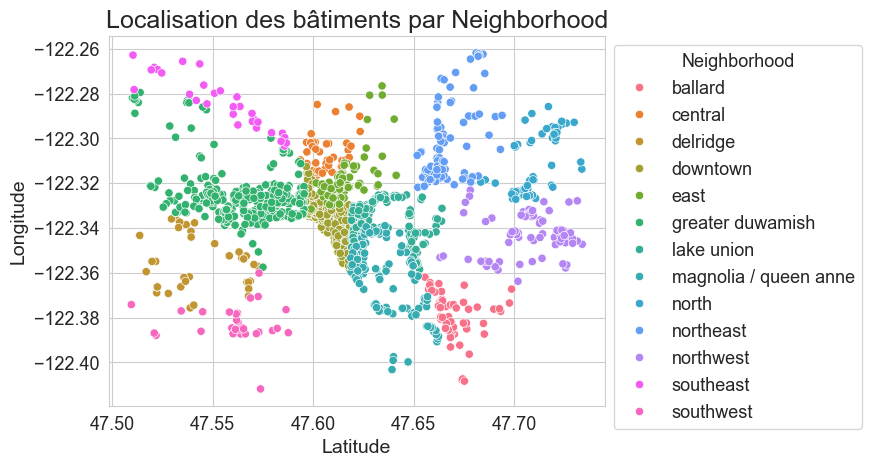

In [62]:
# Localisation des bâtiments par'Neighborhood'
fig, ax = plt.subplots(1,1)

sns.scatterplot(data = building_data.sort_values(feature),
                x = 'Latitude',
                y = 'Longitude',
                hue = feature,
                ax = ax)

ax.set_title(f"Localisation des bâtiments par {feature}")
ax.legend(title = feature,  bbox_to_anchor=(1, 1, 0, 0))
plt.show()

`Neighborhood` est une variable pertinente pour l'analyse.

- **CouncilDistrictCode**

In [63]:
# Définition de la variable
feature = 'CouncilDistrictCode'

definition(feature)

**CouncilDistrictCode** : Property City of Seattle council district.

In [64]:
# Nombre de bâtiments par 'CouncilDistrictCode'
building_data[feature].value_counts().reset_index().sort_values(feature)

CouncilDistrictCode  count
6                    1     95
1                    2    360
2                    3    183
3                    4    157
4                    5    115
5                    6    101
0                    7    503

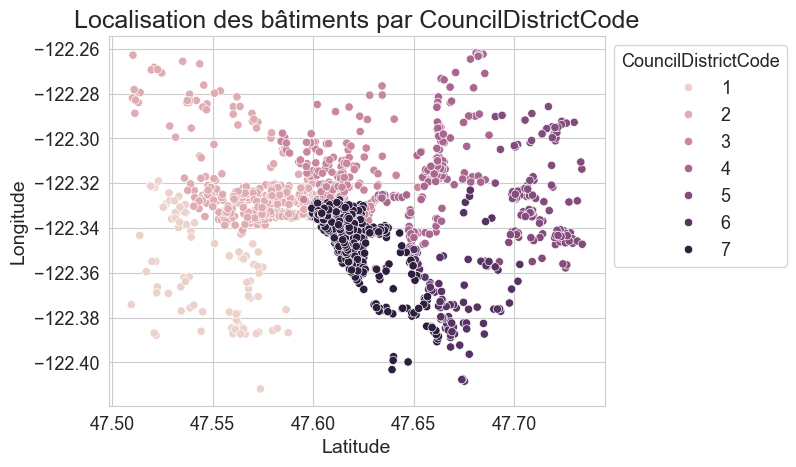

In [65]:
# Localisation des bâtiments par'CouncilDistrictCode'
fig, ax = plt.subplots(1,1)

sns.scatterplot(data = building_data.sort_values(feature),
                x = 'Latitude',
                y = 'Longitude',
                hue = feature,
                ax = ax)

ax.set_title(f"Localisation des bâtiments par {feature}")
ax.legend(title =feature,  bbox_to_anchor=(1, 1, 0, 0))
plt.show()

`CouncilDistrictCode` n'est pas retenue pour la modélisation : `Neighborhood` est plus pertinente car plus de modalités et permet de mieux découper les bâtiments par localisation.

In [66]:
# Suppression de la variable
to_drop = [feature]+['Latitude', 'Longitude']
building_data = building_data.drop(to_drop, axis=1)

In [67]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Suppression de variables', 
            to_drop, 
            "Variables non retenues"] 
           )

## <font color='#46abe6'>2.5. Variables utilisation et structure du bâtiment<a class="anchor" id="2_5"></a></font>

- **PrimaryPropertyType, LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType**

In [68]:
# Définition de la variable
features = ['PrimaryPropertyType', 
            'LargestPropertyUseType',
            'SecondLargestPropertyUseType',
            'ThirdLargestPropertyUseType', 
            'ListOfAllPropertyUseTypes']

for feature in features:
    definition(feature)

**PrimaryPropertyType** : The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.

**LargestPropertyUseType** : The largest use of a property (e.g. office, retail store) by GFA.

**SecondLargestPropertyUseType** : The second largest use of a property (e.g. office, retail store) by GFA.

**ThirdLargestPropertyUseType** : The third largest use of a property (e.g. office, retail store) by GFA.

**ListOfAllPropertyUseTypes** : All property uses reported in Portfolio Manager

In [69]:
# Modalités de PrimaryPropertyType
pd.set_option('display.max_rows', None)
display(building_data['PrimaryPropertyType'].value_counts().reset_index())
pd.reset_option('display.max_rows')

PrimaryPropertyType  count
0   Small- and Mid-Sized Office    286
1                         Other    236
2                     Warehouse    185
3                  Large Office    168
4            Mixed Use Property    109
5                  Retail Store     85
6                         Hotel     75
7              Worship Facility     69
8           Distribution Center     53
9   Supermarket / Grocery Store     40
10               Medical Office     39
11                  K-12 School     38
12        Self-Storage Facility     28
13               Residence Hall     21
14        Senior Care Community     20
15                   University     18
16       Refrigerated Warehouse     12
17                   Restaurant     11
18                     Hospital     10
19                   Laboratory     10
20         Low-Rise Multifamily      1

* Catégorie 'Low-Rise Multifamily', 'Residence Hall' : bâtiment destiné à l'habitation => à éliminer.
* Catégories 'Mixed Use Property' et 'Other' qui contiennent des catégories représentant moins de 50% de la surface totale.

In [70]:
# Filtre : exclure 'Low-Rise Multifamily', 'Residence Hall' 
building_data = building_data[~building_data['PrimaryPropertyType'].isin(['Low-Rise Multifamily', 'Residence Hall'])]

In [71]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Filtre', 
            'PrimaryPropertyType', 
            "Exclure 'Low-Rise Multifamily', 'Residence Hall' = bâtiments résidentiels"] 
           )

In [72]:
# Sous-catégories "LargestPropertyUseType" pour 'PrimaryPropertyType' = ('Mixed Use Property', 'Other') 
building_data[building_data.PrimaryPropertyType.isin(['Mixed Use Property', 'Other'])
             ].groupby(['PrimaryPropertyType', 'LargestPropertyUseType'])['OSEBuildingID'].count().reset_index()

PrimaryPropertyType                             LargestPropertyUseType  \
0   Mixed Use Property                                        Bank Branch   
1   Mixed Use Property                                Distribution Center   
2   Mixed Use Property                     Fitness Center/Health Club/Gym   
3   Mixed Use Property                                              Hotel   
4   Mixed Use Property                                         Laboratory   
5   Mixed Use Property                                     Medical Office   
6   Mixed Use Property                                Multifamily Housing   
7   Mixed Use Property                         Non-Refrigerated Warehouse   
8   Mixed Use Property                                             Office   
9   Mixed Use Property                                              Other   
10  Mixed Use Property                                  Other - Education   
11  Mixed Use Property              Other - Entertainment/Public Assembly   
12  Mixed Use Property                                 Other - Recreation   
13  Mixed Use Property                             Other - Restaurant/Bar   
14  Mixed Use Property                                            Parking   
15  Mixed Use Property                           Residence Hall/Dormitory   
16  Mixed Use Property                                         Restaurant   
17  Mixed Use Property                                       Retail Store   
18  Mixed Use Property                                Social/Meeting Hall   
19  Mixed Use Property                                         Strip Mall   
20  Mixed Use Property                          Supermarket/Grocery Store   
21               Other                                    Adult Education   
22               Other                              Automobile Dealership   
23               Other                                        Bank Branch   
24               Other                                         Courthouse   
25               Other                                        Data Center   
26               Other                                   Financial Office   
27               Other                                       Fire Station   
28               Other                     Fitness Center/Health Club/Gym   
29               Other                                       Food Service   
30               Other                                            Library   
31               Other                                   Lifestyle Center   
32               Other                     Manufacturing/Industrial Plant   
33               Other                                      Movie Theater   
34               Other                                             Museum   
35               Other                                              Other   
36               Other                                  Other - Education   
37               Other              Other - Entertainment/Public Assembly   
38               Other                        Other - Lodging/Residential   
39               Other                                       Other - Mall   
40               Other                            Other - Public Services   
41               Other                                 Other - Recreation   
42               Other                                   Other - Services   
43               Other                                    Other - Utility   
44               Other                           Other/Specialty Hospital   
45               Other                                            Parking   
46               Other                                    Performing Arts   
47               Other  Personal Services (Health/Beauty, Dry Cleaning...   
48               Other                                     Police Station   
49               Other                                 Pre-school/Daycare   
50               Other                               Prison/Incarceration   

Il reste des bâtiments dont la majeur partie de la surface est à usage résidentiel -> à supprimer.

In [73]:
# Mots clés pour l'usage du bâtiment
property_use = ['residential', 'residence', 'family']

# Création d'un pattern avec les mots clé avec une condition 'ou'
pattern = '|'.join(map(re.escape, property_use))

# Filtre sur les lignes contenant un des mots clé (ignore le NaN et les majuscules)
building_data = building_data[~building_data['LargestPropertyUseType'].str.contains(pattern, case=False, na=False)]

In [74]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Filtre', 
            'LargestPropertyUseType', 
            "Exclure les bâtiments dont l'usage est majoritairement résidentiel ('residential', 'residence', 'family')"] 
           )

In [75]:
# Valeurs manquantes
features_na = round(building_data[features].isna().mean()*100,1)
display(Markdown(f"Beaucoup de valeurs manquantes pour {' et '.join(features_na[features_na>30].index[i] for i in range(0, len(features_na[features_na>30])))} :"))
display(features_na)

Beaucoup de valeurs manquantes pour SecondLargestPropertyUseType et ThirdLargestPropertyUseType :

PrimaryPropertyType              0.0
LargestPropertyUseType           0.3
SecondLargestPropertyUseType    45.1
ThirdLargestPropertyUseType     77.8
ListOfAllPropertyUseTypes        0.0
dtype: float64

In [76]:
# Valeurs manquantes de 'LargestPropertyUseType'
data = building_data.loc[building_data['LargestPropertyUseType'].isna(), ['PrimaryPropertyType',
                                                                   'PropertyGFATotal',
                                                                   'PropertyGFABuilding(s)', 
                                                                   'LargestPropertyUseType', 
                                                                   'LargestPropertyUseTypeGFA']]
display(data)

PrimaryPropertyType  PropertyGFATotal  PropertyGFABuilding(s)  \
353         Self-Storage Facility            111445                  111445   
1147                        Hotel             61721                   61721   
2414  Small- and Mid-Sized Office             48350                   48350   
2459                   Restaurant             28800                   28800   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  
353                     NaN                        NaN  
1147                    NaN                        NaN  
2414                    NaN                        NaN  
2459                    NaN                        NaN

Les 'NaN' de `LargestPropertyUseType` peuvent être imputées par la catégorie correspondant à `PrimaryPropertyType`.

In [77]:
# Correspondance 'PrimaryPropertyType', 'LargestPropertyUseType'
use_list = list(data['PrimaryPropertyType'].unique())

match_dict = building_data[(building_data['PrimaryPropertyType'].isin(use_list))&
                           (building_data['LargestPropertyUseType'].notna())]\
        .groupby('LargestPropertyUseType')['PrimaryPropertyType'].unique().apply(list).to_dict()

# Supprimer 'Other - Restaurant/Bar' de la liste associée à la clé 'Restaurant'
if 'Other - Restaurant/Bar' in match_dict:
    match_dict.pop('Other - Restaurant/Bar')
    
# Remplacer les 'NaN de 'LargestPropertyUseType' en fonction de la Correspondance avec 'PrimaryPropertyType'
building_data.loc[building_data['LargestPropertyUseType'].isna(), 'LargestPropertyUseType'] =\
    building_data['PrimaryPropertyType'].apply(lambda x: map_subcat_to_cat(x, match_dict))

Les 'NaN' de `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType` peuvent être remplacés par 'not available' : Certaines propriétés peuvent n'avoir qu'un seul usage 

In [78]:
# Remplacer les 'NaN de 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType' par 'non relevant'
columns_tofill = ['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

for col in columns_tofill:
    building_data[col] = building_data[col].fillna('not available')

In [79]:
# Valeurs manquantes
features_na = round(building_data[features].isna().mean()*100,1)
display(Markdown("Plus de valeurs manquantes :"))
display(features_na)

Plus de valeurs manquantes :

PrimaryPropertyType             0.0
LargestPropertyUseType          0.0
SecondLargestPropertyUseType    0.0
ThirdLargestPropertyUseType     0.0
ListOfAllPropertyUseTypes       0.0
dtype: float64

* `PrimaryPropertyType`est une variable à retenir pour la modélisation. L'utilisation du bâtiment impacte sa consommation d'énergie et ses émissions carbones. A voir s'il sera nécessaire de regrouper certains groupes.

* `LargestPropertyUseType` : peut être utile pour basculer 'Mixed Use Property' et 'Other' dans les catégories correspondantes

* `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType`, `ListOfAllPropertyUseTypes` : non utilisés pour le moment, conservés pour l'analyse des outliers.

- **Surfaces**

In [80]:
# Définition de la variable
features = ['PropertyGFATotal',
            'PropertyGFAParking', 
            'PropertyGFABuilding(s)',
            'LargestPropertyUseTypeGFA', 
            'SecondLargestPropertyUseTypeGFA', 
            'ThirdLargestPropertyUseTypeGFA']

for feature in features:
    definition(feature)

**PropertyGFATotal** : Total building and parking gross floor area.

**PropertyGFAParking** : Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).

**PropertyGFABuilding(s)** : Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc.

**LargestPropertyUseTypeGFA** : The gross floor area (GFA) of the largest use of the property

**SecondLargestPropertyUseTypeGFA** : The gross floor area (GFA) of the second largest use of the property.

**ThirdLargestPropertyUseTypeGFA** : The gross floor area (GFA) of the third largest use of the property.

In [81]:
# Valeurs manquantes
features_na = round(building_data[features].isna().mean()*100,1)
display(Markdown(f"Beaucoup de valeurs manquantes pour {' et '.join(features_na[features_na>30].index[i] for i in range(0, len(features_na[features_na>30])))} :"))
display(features_na)

Beaucoup de valeurs manquantes pour SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA :

PropertyGFATotal                    0.0
PropertyGFAParking                  0.0
PropertyGFABuilding(s)              0.0
LargestPropertyUseTypeGFA           0.3
SecondLargestPropertyUseTypeGFA    45.1
ThirdLargestPropertyUseTypeGFA     77.8
dtype: float64

In [82]:
# Valeurs manquantes de 'LargestPropertyUseTypeGFA'
data = building_data.loc[building_data['LargestPropertyUseTypeGFA'].isna(), ['PrimaryPropertyType',
                                                                   'PropertyGFATotal',
                                                                   'PropertyGFABuilding(s)', 
                                                                   'LargestPropertyUseType', 
                                                                   'LargestPropertyUseTypeGFA']]
display(data)

PrimaryPropertyType  PropertyGFATotal  PropertyGFABuilding(s)  \
353         Self-Storage Facility            111445                  111445   
1147                        Hotel             61721                   61721   
2414  Small- and Mid-Sized Office             48350                   48350   
2459                   Restaurant             28800                   28800   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  
353   Self-Storage Facility                        NaN  
1147                  Hotel                        NaN  
2414                 Office                        NaN  
2459             Restaurant                        NaN

Les 'NaN' de `LargestPropertyUseTypeGFA` peuvent être imputées par la valeur correspondante de `PropertyGFABuilding(s)` (une seule utilisation du bâtiment).

In [83]:
# Remplacer les 'NaN de 'LargestPropertyUseTypeGFA' par 'PropertyGFABuilding(s)'
building_data.loc[building_data['LargestPropertyUseTypeGFA'].isna(), 'LargestPropertyUseTypeGFA'] =\
    building_data['PropertyGFABuilding(s)']

Les 'NaN' de `SecondLargestPropertyUseTypeGFA`, `ThirdLargestPropertyUseTypeGFA` peuvent être remplacés par '0 : Certaines propriétés peuvent n'avoir qu'un seul usage 

In [84]:
# Remplacer les 'NaN de 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA' par 'non relevant'
columns_tofill = ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

for col in columns_tofill:
    building_data[col] = building_data[col].fillna(0)

In [85]:
# Valeurs manquantes
features_na = round(building_data[features].isna().mean()*100,1)
display(Markdown("Plus de valeurs manquantes :"))
display(features_na)

Plus de valeurs manquantes :

PropertyGFATotal                   0.0
PropertyGFAParking                 0.0
PropertyGFABuilding(s)             0.0
LargestPropertyUseTypeGFA          0.0
SecondLargestPropertyUseTypeGFA    0.0
ThirdLargestPropertyUseTypeGFA     0.0
dtype: float64

In [86]:
# Relation entre les surfaces `PropertyGFATotal` = `PropertyGFAParking` + `PropertyGFABuilding(s)`
GFA_df = building_data[features].copy()

relation = '`PropertyGFATotal` = `PropertyGFAParking` + `PropertyGFABuilding(s)`'
GFA_df['GFA_estimate'] = GFA_df['PropertyGFAParking'] + GFA_df['PropertyGFABuilding(s)']

percent = round(GFA_df[GFA_df['GFA_estimate']==GFA_df['PropertyGFATotal']].shape[0]/GFA_df.shape[0]*100)
display(Markdown(f' * La relation {relation} est vérifiée dans {percent}% des cas.'))

 * La relation `PropertyGFATotal` = `PropertyGFAParking` + `PropertyGFABuilding(s)` est vérifiée dans 100% des cas.

* Les variables  `PropertyGFATotal`,  `PropertyGFAParking` et `PropertyGFABuilding(s)` seront utilisées pour la modélisation.

In [87]:
# Relation entre les surfaces `PropertyGFATotal` = `LargestPropertyUseTypeGFA` + `SecondLargestPropertyUseTypeGFA` + `ThirdLargestPropertyUseTypeGFA`
acceptance = 0.02
relation = f'`PropertyGFATotal` (+/- {acceptance*100}%) = `LargestPropertyUseTypeGFA` + `SecondLargestPropertyUseTypeGFA` + `ThirdLargestPropertyUseTypeGFA`'
GFA_df['GFA_estimate'] = (GFA_df['LargestPropertyUseTypeGFA'] + 
                          GFA_df['SecondLargestPropertyUseTypeGFA'] +
                          GFA_df['ThirdLargestPropertyUseTypeGFA'])

# Relation à tester, pourcentage des cas où la relation est vérifié
mask = ((abs(GFA_df['GFA_estimate']-GFA_df['PropertyGFATotal'])/GFA_df['PropertyGFATotal']) <= acceptance)
percent = round(GFA_df[mask].shape[0]/GFA_df.shape[0]*100)
display(Markdown(f'* La relation {relation} est vérifiée dans {percent}% des cas.'))

ecart = 0.05
percent = round(GFA_df[(GFA_df['GFA_estimate']-GFA_df['PropertyGFATotal'])>(ecart*GFA_df['PropertyGFATotal'])].shape[0]/GFA_df.shape[0]*100)
display(Markdown(f"* Dans {percent}% des cas, l'estimation est {round(ecart*100)}% au-dessus de `PropertyGFATotal`."))

* La relation `PropertyGFATotal` (+/- 2.0%) = `LargestPropertyUseTypeGFA` + `SecondLargestPropertyUseTypeGFA` + `ThirdLargestPropertyUseTypeGFA` est vérifiée dans 55% des cas.

* Dans 15% des cas, l'estimation est 5% au-dessus de `PropertyGFATotal`.

* Une analyse des valeurs aberrantes est nécessaire pour LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA.

- **YearBuilt, NumberofBuildings, NumberofFloors**

In [88]:
# Définition de la variable
features = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors']

for feature in features:
    definition(feature)

**YearBuilt** : Year in which a property was constructed or underwent a complete renovation.

**NumberofBuildings** : Number of buildings included in the property's report. In cases where a property is reporting as a campus, multiple buildings may be included in one report.

**NumberofFloors** : Number of floors reported in Portfolio Manager

In [89]:
# Valeurs manquantes
round(building_data[features].isna().mean()*100)

YearBuilt            0.0
NumberofBuildings    0.0
NumberofFloors       0.0
dtype: float64

Aucune valeur manquante pour `YearBuilt`, `NumberofBuildings` et `NumberofFloors`.

In [90]:
# Modalités de 'NumberofBuildings'
building_data['NumberofBuildings'].value_counts().reset_index()

NumberofBuildings  count
0                1.0   1389
1                0.0     50
2                2.0     14
3                3.0     10
4                6.0      4
5                5.0      3
6                4.0      2
7                8.0      2
8                9.0      1
9                7.0      1

In [91]:
# Inspection de 'NumberofBuildings' = 0
display(Markdown(f"{building_data[building_data['NumberofBuildings']==0].shape[0]} lignes avec 0 comme nombre de bâtiment."))
display(building_data[building_data['NumberofBuildings']==0].head())

50 lignes avec 0 comme nombre de bâtiment.

OSEBuildingID          PrimaryPropertyType  \
63              89               Medical Office   
76             113  Small- and Mid-Sized Office   
160            257                    Warehouse   
201            322                 Large Office   
241            366  Small- and Mid-Sized Office   

                              PropertyName           Address  \
63               Polyclinic North && South  1200 Harvard Ave   
76                                   KCTS9     401 Mercer St   
160  Harbor Island: Warehouse E - DNRP-SWD  3235 16TH AVE SW   
201  Cox Media Group Seattle KIRO TV (322)      2801 3rd Ave   
241     University District Office Buiding   1107 NE 45th St   

              Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
63                    east       1965                0.0               3   
76   magnolia / queen anne       1986                0.0               2   
160       greater duwamish       1916                0.0               4   
201               downtown       1968                0.0               3   
241              northeast       1961                0.0               5   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
63             179014                   0                  179014   
76              66240                2352                   63888   
160             79600                   0                   79600   
201            100734               26731                   74003   
241             99005                   0                   99005   

                             ListOfAllPropertyUseTypes  \
63                                      Medical Office   
76   Data Center, Distribution Center, Office, Park...   
160                         Non-Refrigerated Warehouse   
201                                             Office   
241                                             Office   

         LargestPropertyUseType  LargestPropertyUseTypeGFA  \
63               Medical Office                   179014.0   
76                       Office                    45900.0   
160  Non-Refrigerated Warehouse                    79600.0   
201                      Office                   100734.0   
241                      Office                    79555.0   

    SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
63                 not available                              0.0   
76                   Data Center                           5181.0   
160                not available                              0.0   
201                not available                              0.0   
241                not available                              0.0   

    ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
63                not available                             0.0   
76          Distribution Center                          4551.0   
160               not available                             0.0   
201               not available                             0.0   
241               not available                             0.0   

     ENERGYSTARScore  SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
63              48.0          16701055.00             0.0          9886484.0   
76               NaN           4166306.25             0.0          4166305.0   
160             34.0           2411402.25             0.0          2411402.0   
201             20.0           9788717.00             0.0          9788716.0   
241             70.0           4728488.50             0.0          2863212.0   

     NaturalGas(kBtu)  TotalGHGEmissions  
63          6814570.0             430.84  
76                0.0              29.04  
160               0.0              16.81  
201               0.0              68.24  
241         1865277.0             119.03

Il y a bien des bâtiments à ces adresses : remplacer 0 -> 1.

In [92]:
# Remplacer 0 par 1
building_data.loc[building_data['NumberofBuildings']==0, 'NumberofBuildings'] = 1

In [93]:
# Type de propriétés avec plusieurs bâtiments
df_temp = building_data[building_data['NumberofBuildings']>1].sort_values('NumberofBuildings', ascending=False)
display(Markdown(f"Propriétés avec plus de 1 bâtiment : {round(df_temp.shape[0]/building_data.shape[0]*100)}% du dataset."))
display(df_temp['PrimaryPropertyType'].value_counts().reset_index())
display(df_temp.head(5))

Propriétés avec plus de 1 bâtiment : 3% du dataset.

PrimaryPropertyType  count
0                         Other     13
1                      Hospital      6
2         Self-Storage Facility      3
3            Mixed Use Property      2
4                   K-12 School      2
5           Distribution Center      2
6                     Warehouse      2
7                    University      2
8                         Hotel      2
9   Small- and Mid-Sized Office      1
10               Medical Office      1
11                 Large Office      1

OSEBuildingID PrimaryPropertyType  \
170             276            Hospital   
3168          49705               Other   
1672          23071            Hospital   
618             828            Hospital   
124             198            Hospital   

                                 PropertyName  \
170                 Harborview Medical Center   
3168                                 Magnuson   
1672                Main Hospital - All Wings   
618                        Swedish First Hill   
124   Seattle Children's Hospital Main Campus   

                              Address Neighborhood  YearBuilt  \
170                      325 9th Ave.         east       2000   
3168           7400 Sand Point Way NE    northeast       1929   
1672  Facilities Management MS: B-120    northwest       1966   
618                      747 Broadway         east       1994   
124            4800 Sand Point Way NE    northeast       1953   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
170                 9.0               8           1158691                   0   
3168                8.0               0            502030                   0   
1672                8.0               1            415632                   0   
618                 7.0              14           1765970                   0   
124                 6.0              10            879000                   0   

      PropertyGFABuilding(s)                       ListOfAllPropertyUseTypes  \
170                  1158691  Hospital (General Medical & Surgical), Parking   
3168                  502030                              Other - Recreation   
1672                  415632  Hospital (General Medical & Surgical), Parking   
618                  1765970  Hospital (General Medical & Surgical), Parking   
124                   879000           Hospital (General Medical & Surgical)   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
170   Hospital (General Medical & Surgical)                  1350182.0   
3168                     Other - Recreation                   564258.0   
1672  Hospital (General Medical & Surgical)                   483520.0   
618   Hospital (General Medical & Surgical)                  1639334.0   
124   Hospital (General Medical & Surgical)                   879000.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
170                       Parking                         387651.0   
3168                not available                              0.0   
1672                      Parking                         266833.0   
618                       Parking                         441551.0   
124                 not available                              0.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
170                not available                             0.0   
3168               not available                             0.0   
1672               not available                             0.0   
618                not available                             0.0   
124                not available                             0.0   

      ENERGYSTARScore  SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
170              29.0          293090784.0     122575032.0        168683602.0   
3168              NaN           18470340.0             0.0          9359884.0   
1672             85.0           98960776.0             0.0         42864158.0   
618              54.0          291614432.0     134943456.0        139354828.0   
124              10.0          253832464.0             0.0        115641210.0   

      NaturalGas(kBtu)  TotalGHGEmissions  
170          1832129.0           10734.57  
3168         9110455.0             549.11  
1672        56096612.0            3278.11  
618         17316120.0           12307.16  
124        138191238.0            8145.52

Vérification sur Google maps : les hopitaux sont bien composés de plusieurs bâtiments.

2 bâtiments peut correspondre à des tours jumelles.
Les références avec plus de 2 bâtiments ne pourront pas être utilisées pour la modélisation : cala fausse l'analyse des données et la comparaison des bâtiments et crées de trop grandes différences. Et de plus, nous ne pouvons pas calculer la surface par étage du bâtiment, nous ne savons pas si tous les bâtiments ont le même nombre d'étage, s'ils ont été construits la même année ...

In [94]:
# Filtrer sur les propriétés <= à 2 bâtiments
building_data = building_data[building_data['NumberofBuildings']<=2]

In [95]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Filtre', 
            'NumberofBuildings', 
            "'NumberofBuildings'<=2"] 
           )

* `YearBuilt` est une variable pertinente pour la modélisation : l'année de construction / rénovation complète du bâtiment est un bon indicateur de sa qualité environnementale (isolation thermique, équipements basse consommation, ...).
* `NumberofFloors` et `NumberofBuildings` seront conservés dans l'analyse.

## <font color='#46abe6'>2.6. Conclusion - Variables sélectionnées<a class="anchor" id="2_6"></a></font>

* Les variables retenues pour la modélisation sont : 
    - PrimaryUseType
    - Neighborhood
    - YearBuilt
    - NumberofBuildings
    - NumberofFloors
    - PropertyGFATotal
    - PropertyGFAParking
    - PropertyGFABuilding(s)
    - SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu) : à transformer pour donner une information sur la(les) source(s) d'énergie et le mix énergétique.
    
* Les variables cibles sont : SiteEnergyUse(kBtu), TotalGHGEmissions

* Autres variables :
    - NumberofBuildings
    - `PropertyName` et `Address`  sont conservées pour l'analyse mais ne seront  retenues comme variable pertinente pour la modélisation.
    - `LargestPropertyUseType` : peut être utile pour basculer 'Mixed Use Property' et 'Other' dans les catégories correspondantes
    - `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType`, `ListOfAllPropertyUseTypes` : non utilisés pour le moment

# <font color='#0a389f'>Partie 3 - Identification et traitement des valeurs aberrantes<a class="anchor" id="partie3"></a></font>

## <font color='#46abe6'>3.1. Description des variables quantitatives<a class="anchor" id="3_1"></a></font>

In [96]:
selection = ['YearBuilt',
             'NumberofFloors',
             'NumberofBuildings',
             'PropertyGFATotal', 
             'PropertyGFAParking',
             'PropertyGFABuilding(s)',
             'LargestPropertyUseTypeGFA',
             'SecondLargestPropertyUseTypeGFA',
             'ThirdLargestPropertyUseTypeGFA',
             'ENERGYSTARScore',
             'SiteEnergyUse(kBtu)', 
             'SteamUse(kBtu)',
             'Electricity(kBtu)', 
             'NaturalGas(kBtu)',
             'TotalGHGEmissions']

In [97]:
# Description des variables
round(building_data[selection].describe(),2)

YearBuilt  NumberofFloors  NumberofBuildings  PropertyGFATotal  \
count    1453.00         1453.00            1453.00           1453.00   
mean     1961.32            4.33               1.01         109430.25   
std        32.70            6.90               0.10         182500.27   
min      1900.00            0.00               1.00          11285.00   
25%      1930.00            1.00               1.00          28800.00   
50%      1965.00            2.00               1.00          47237.00   
75%      1988.00            4.00               1.00         102796.00   
max      2015.00           99.00               2.00        1952220.00   

       PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count             1453.00                 1453.00                    1453.00   
mean             14450.36                94979.89                   87647.61   
std              44842.88               156375.25                  145298.75   
min                  0.00                 3636.00                    5656.00   
25%                  0.00                27800.00                   24990.00   
50%                  0.00                45271.00                   41340.00   
75%                  0.00                91649.00                   88434.00   
max             512608.00              1632820.00                 1680937.00   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                          1453.00                         1453.00   
mean                          18513.68                         2894.47   
std                           46729.70                        14127.17   
min                               0.00                            0.00   
25%                               0.00                            0.00   
50%                             300.00                            0.00   
75%                           13534.00                            0.00   
max                          438756.00                       303910.00   

       ENERGYSTARScore  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
count           953.00         1.453000e+03         1453.00   
mean             63.58         7.039219e+06       342011.78   
std              28.77         1.381973e+07      2674339.11   
min               1.00         5.713320e+04            0.00   
25%              44.00         1.215156e+06            0.00   
50%              70.00         2.619088e+06            0.00   
75%              88.00         6.963616e+06            0.00   
max             100.00         2.746822e+08     73885472.00   

       Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
count       1.453000e+03           1453.00            1453.00  
mean        5.171320e+06        1478419.46             140.97  
std         1.160185e+07        3387763.91             312.32  
min        -1.154170e+05              0.00              -0.80  
25%         7.232400e+05              0.00              19.73  
50%         1.659964e+06         424865.00              47.94  
75%         5.078203e+06        1396981.00             134.80  
max         2.745325e+08       54671394.00            6330.91

* `NumberofFloors` = 0 -> valeurs aberrantes à écarter	
* `Electricity(kBtu)` < 0

## <font color='#46abe6'>3.2. Identification des valeurs aberrantes avec la méthode du z-score<a class="anchor" id="3_2"></a></font>

In [98]:
# Liste des variables à inclure dans l'affichage des outliers
res_var=['OSEBuildingID',
         'PrimaryPropertyType',
         'PropertyName',
         'Address',
         'NumberofFloors',
         'PropertyGFATotal']
         
# Représentation de la distribution, boxplots, et échantillons de 10 outliers identifiés avec la méthode du Z-score
print_outlier(building_data, selection, res_var)

- **YearBuilt** : Nombre d'outliers détectés => 0

- **NumberofFloors** : Nombre d'outliers détectés => 52

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                    PropertyName  \
1359          21611    Worship Facility  Seattle Chinese Baptist Church   
559             775        Large Office          Columbia Center - 2015   
233             357        Large Office  Seattle Municipal Tower (2030)   
292             422        Large Office                Two Union Square   
271             399        Large Office               1201 Third Avenue   

                       Address  NumberofFloors  PropertyGFATotal  
1359  5801 Beacon Avenue South              99             21948  
559             701 5th Avenue              76           1952220  
233           700 Fifth Avenue              63           1354987  
292              601 Union St.              56           1605578  
271               1201 3rd ave              55           1400000

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType                       PropertyName  \
496             677      Medical Office              Cabrini Medical Tower   
21               27               Other  King County Correctional Facility   
560             754        Large Office               Eighth & Olive - New   
2530          25992  Mixed Use Property    2201 / Enso Condominiums - SEDO   
280             410               Hotel                      Motif Seattle   

                                Address  NumberofFloors  PropertyGFATotal  
496                    901 Boren Avenue              19            319911  
21                          500 5TH AVE              19            385274  
560                       720 Olive Way              19            383515  
2530  2201 9th Ave. / 820 Blanchard St.              19           1206670  
280                        1414 4th Ave              19            332067

- **NumberofBuildings** : Nombre d'outliers détectés => 14

5 premiers outliers : 


OSEBuildingID    PrimaryPropertyType                     PropertyName  \
80             117                  Hotel                   UNIVERSITY INN   
319            456           Large Office  1100 Dexter-RREEF SeaDPD ID 456   
353            496  Self-Storage Facility                 Market St Center   
463            624                  Other       South Occidental Warehouse   
631            851             University    SCCC SEATTLE VOCATIONAL INST.   

                      Address  NumberofFloors  PropertyGFATotal  \
80      4140 ROOSEVELT WAY NE               4             50017   
319  1100 Dexter Avenue North               5            213283   
353     2811 NW Market Street               2            111445   
463     1900 Occidental Ave S               2            125519   
631         2120 S JACKSON ST               4            114000   

     NumberofBuildings  
80                 2.0  
319                2.0  
353                2.0  
463                2.0  
631                2.0

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType                   PropertyName  \
1659          23022               Other               Northgate Campus   
2051          24253      Medical Office  Springbrook Building LLC 4540   
2138          24579               Other                 SODO Park Bldg   
3110          33527          University         SCCC WOOD CONSTRUCTION   
3178          49718               Other         South Transfer Station   

                    Address  NumberofFloors  PropertyGFATotal  \
1659       10510 5th Ave NE               1             30498   
2051  4540 Sandpoint Way NE               4             36932   
2138     3200 1st ave south               1             27760   
3110         2310 S LANE ST               1             57468   
3178   130 South Kenyon St.               2            137138   

      NumberofBuildings  
1659                2.0  
2051                2.0  
2138                2.0  
3110                2.0  
3178                2.0

- **PropertyGFATotal** : Nombre d'outliers détectés => 55

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                PropertyName  \
559            775        Large Office      Columbia Center - 2015   
292            422        Large Office            Two Union Square   
490            659        Large Office  Russell Investments Center   
155            245               Other                 CenturyLink   
273            402        Large Office              US Bank Centre   

                       Address  NumberofFloors  PropertyGFATotal  
559             701 5th Avenue              76           1952220  
292              601 Union St.              56           1605578  
490               1301 2nd Ave              42           1592914  
155  800 Occidental Ave. South               6           1585960  
273            1420 5th Avenue              46           1536606

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType                       PropertyName  \
570             764        Large Office  Financial Center - COS Compliance   
3324          50045        Large Office                     Sidneysea, LLC   
215             337        Large Office                         1800 Ninth   
3320          50037        Large Office   MAPS 325 Ninth Avenue North, LLC   
239             364        Large Office              UW Tower Bldg Complex   

                   Address  NumberofFloors  PropertyGFATotal  
570        1215 4th Avenue              29            489182  
3324  400 9th Avenue North              12            483397  
215        1800 9th Avenue              16            480840  
3320  325 9th Avenue North              12            480702  
239      4333 Brooklyn Ave              23            474546

- **PropertyGFAParking** : Nombre d'outliers détectés => 66

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType        PropertyName  \
273            402        Large Office      US Bank Centre   
307            438      Medical Office  1101 Madison Tower   
292            422        Large Office    Two Union Square   
229            353        Large Office        Safeco Plaza   
163            263               Other          Building 1   

                   Address  NumberofFloors  PropertyGFATotal  \
273        1420 5th Avenue              46           1536606   
307           1101 Madison              14            690158   
292          601 Union St.              56           1605578   
229     1001 Fourth Avenue              49           1123435   
163  316 NE Thornton Place               6            419848   

     PropertyGFAParking  
273              512608  
307              407795  
292              389860  
229              368980  
163              335109

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType                  PropertyName  \
616            861      Medical Office      Patricia Steele Building   
334            470          Laboratory             401 Terry (ID470)   
474            637  Mixed Use Property     Stadium Innovation Center   
343            482        Large Office    Westlake Terry - West SEDO   
309            440  Mixed Use Property  Fisher Plaza - West Building   

                  Address  NumberofFloors  PropertyGFATotal  \
616          401 Broadway               5            275130   
334       401 TERRY AVE N               4            241159   
474       1531 Utah Ave S               6            286000   
343  320 Westlake Ave. N.               6            303103   
309         100 4th Ave N               6            213834   

     PropertyGFAParking  
616              112980  
334              111793  
474              111774  
343              109905  
309              104922

- **PropertyGFABuilding(s)** : Nombre d'outliers détectés => 52

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                PropertyName  \
559            775        Large Office      Columbia Center - 2015   
490            659        Large Office  Russell Investments Center   
477            640        Large Office            Starbucks Center   
221            345        Large Office            999 Third Avenue   
155            245               Other                 CenturyLink   

                        Address  NumberofFloors  PropertyGFATotal  \
559              701 5th Avenue              76           1952220   
490                1301 2nd Ave              42           1592914   
477         2401 Utah Ave South               6           1380959   
221  999 3rd Avenue, Suite 1550              47           1323055   
155   800 Occidental Ave. South               6           1585960   

     PropertyGFABuilding(s)  
559                 1632820  
490                 1592914  
477                 1380959  
221                 1323055  
155                 1258280

5 derniers outliers : 


OSEBuildingID  PrimaryPropertyType                  PropertyName  \
558             753                Other                WestinBuilding   
3261          49926           University     SCCC MAIN BROADWAY/EDISON   
3281          49985         Large Office               Amazon Phase VI   
248             373         Large Office          Fourth and Blanchard   
603             805  Distribution Center  Portside Distribution Center   

                         Address  NumberofFloors  PropertyGFATotal  \
558                 2001 6th Ave              33            429405   
3261               1701 BROADWAY               3            428347   
3281        500 9th Avenue North               6            427181   
248           2101 Fourth Avenue              24            543876   
603   4050 E. Marginal Way South               1            411584   

      PropertyGFABuilding(s)  
558                   429405  
3261                  428347  
3281                  427181  
248                   427155  
603                   411584

- **LargestPropertyUseTypeGFA** : Nombre d'outliers détectés => 48

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                    PropertyName  \
559            775        Large Office          Columbia Center - 2015   
155            245               Other                     CenturyLink   
292            422        Large Office                Two Union Square   
233            357        Large Office  Seattle Municipal Tower (2030)   
158            249               Other                    Safeco Field   

                       Address  NumberofFloors  PropertyGFATotal  \
559             701 5th Avenue              76           1952220   
155  800 Occidental Ave. South               6           1585960   
292              601 Union St.              56           1605578   
233           700 Fifth Avenue              63           1354987   
158    1250 First Avenue South               3           1172127   

     LargestPropertyUseTypeGFA  
559                  1680937.0  
155                  1585960.0  
292                  1314475.0  
233                  1191115.0  
158                  1172127.0

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType                       PropertyName  \
3162          49695        Large Office                City Place V - SEDO   
218             341        Large Office             Dexter Horton Building   
21               27               Other  King County Correctional Facility   
488             657  Mixed Use Property               2200 Westlake - SEDO   
204             326        Large Office                     Westlake Tower   

                   Address  NumberofFloors  PropertyGFATotal  \
3162  207 Boren Ave. North              11            526423   
218         710 2nd Avenue              15            388934   
21             500 5TH AVE              19            385274   
488     2200 Westlake Ave.               0            516407   
204        1601 5th Avenue              25            369996   

      LargestPropertyUseTypeGFA  
3162                   400536.0  
218                    388934.0  
21                     385274.0  
488                    385196.0  
204                    383942.0

- **SecondLargestPropertyUseTypeGFA** : Nombre d'outliers détectés => 59

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                PropertyName  \
166            267               Hotel         Grand Hyatt Seattle   
292            422        Large Office            Two Union Square   
302            433        Retail Store     (71367A) SEATTLE Macy's   
273            402        Large Office              US Bank Centre   
490            659        Large Office  Russell Investments Center   

             Address  NumberofFloors  PropertyGFATotal  \
166      721 Pine St               0            934292   
292    601 Union St.              56           1605578   
302  300 PINE STREET               8            861702   
273  1420 5th Avenue              46           1536606   
490     1301 2nd Ave              42           1592914   

     SecondLargestPropertyUseTypeGFA  
166                         438756.0  
292                         389860.0  
302                         380639.0  
273                         377046.0  
490                         348788.0

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType            PropertyName  \
250            375        Large Office         Third and Broad   
49              63               Hotel  Sheraton Seattle Hotel   
360            508               Other  The Park View Building   
247            372        Large Office  Metropolitan Park East   
583            780        Large Office      King Street Center   

                    Address  NumberofFloors  PropertyGFATotal  \
250       2901 Third Avenue               6            396626   
49          1400 6th Avenue              34            994212   
360           601 N 34th St               3            280252   
247       1730 Minor Avenue              20            497513   
583  201 South Jackson A-15               8            446261   

     SecondLargestPropertyUseTypeGFA  
250                         122624.0  
49                          117668.0  
360                         116440.0  
247                         114510.0  
583                         114237.0

- **ThirdLargestPropertyUseTypeGFA** : Nombre d'outliers détectés => 27

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                     PropertyName  \
490             659        Large Office       Russell Investments Center   
477             640        Large Office                 Starbucks Center   
2530          25992  Mixed Use Property  2201 / Enso Condominiums - SEDO   
271             399        Large Office                1201 Third Avenue   
230             354        Large Office                 Fourth & Madison   

                                Address  NumberofFloors  PropertyGFATotal  \
490                        1301 2nd Ave              42           1592914   
477                 2401 Utah Ave South               6           1380959   
2530  2201 9th Ave. / 820 Blanchard St.              19           1206670   
271                        1201 3rd ave              55           1400000   
230                   925 Fourth Avenue              37           1052469   

      ThirdLargestPropertyUseTypeGFA  
490                         303910.0  
477                         220303.0  
2530                        177210.0  
271                         133598.0  
230                         103478.0

5 derniers outliers : 


OSEBuildingID  PrimaryPropertyType                  PropertyName  \
309            440   Mixed Use Property  Fisher Plaza - West Building   
221            345         Large Office              999 Third Avenue   
341            480   Mixed Use Property           307 Westlake - SEDO   
603            805  Distribution Center  Portside Distribution Center   
206            328         Large Office                  1600 Seventh   

                        Address  NumberofFloors  PropertyGFATotal  \
309               100 4th Ave N               6            213834   
221  999 3rd Avenue, Suite 1550              47           1323055   
341        307 Westlake Ave. N.               5            159700   
603  4050 E. Marginal Way South               1            411584   
206                1600 7th Ave              33            791396   

     ThirdLargestPropertyUseTypeGFA  
309                         37721.0  
221                         37595.0  
341                         37406.0  
603                         35760.0  
206                         33110.0

- **ENERGYSTARScore** : Nombre d'outliers détectés => 50

5 premiers outliers : 


OSEBuildingID          PrimaryPropertyType                 PropertyName  \
2115          24514  Supermarket / Grocery Store          OAKTREE PLAZA ASSOC   
280             410                        Hotel                Motif Seattle   
1434          21792                    Warehouse                      OTM 162   
483             651               Medical Office  BMR-530 Fairview Avenue LLC   
1042          20605                    Warehouse               VISKO BUILDING   

                        Address  NumberofFloors  PropertyGFATotal  \
2115         10002 AURORA AVE N               1             45155   
280                1414 4th Ave              19            332067   
1434            5964 6th Ave. S               1             26150   
483   530 Fairview Avenue North               5            129093   
1042  4229 WEST MARGINAL WAY SW               1             31521   

      ENERGYSTARScore  
2115              6.0  
280               6.0  
1434              6.0  
483               6.0  
1042              6.0

5 derniers outliers : 


OSEBuildingID          PrimaryPropertyType  \
601             803  Small- and Mid-Sized Office   
516             703                 Large Office   
512             696                 Large Office   
397             553          Distribution Center   
3065          28033          Distribution Center   

                                 PropertyName                       Address  \
601                           200 SW Michigan               200 SW Michigan   
516                      501 Elliott Ave West           501 Elliot Ave West   
512                Ocean Beauty Seafoods, LLC               1100 W Ewing St   
397   South Seattle Distribution Center- 3844                3844 1ST AVE S   
3065                          Park Manor, LLC  601-619 S. Snoqualmie Street   

      NumberofFloors  PropertyGFATotal  ENERGYSTARScore  
601                3             85126              1.0  
516                4            165111              1.0  
512                1            105100              1.0  
397                1            101101              1.0  
3065               1             28320              1.0

- **SiteEnergyUse(kBtu)** : Nombre d'outliers détectés => 58

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                          PropertyName  \
558             753               Other                        WestinBuilding   
3264          49940            Hospital  Virginia Mason Medical Center - 2149   
1690          23113      Medical Office                        Central Campus   
559             775        Large Office                Columbia Center - 2015   
49               63               Hotel                Sheraton Seattle Hotel   

               Address  NumberofFloors  PropertyGFATotal  SiteEnergyUse(kBtu)  
558       2001 6th Ave              33            429405          274682208.0  
3264    925 Seneca St.               8            374466          163945984.0  
1690  201 16th Ave. E.               3            591981          102673696.0  
559     701 5th Avenue              76           1952220           92937640.0  
49     1400 6th Avenue              34            994212           80469216.0

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType  \
280             410               Hotel   
3261          49926          University   
77              114        Large Office   
550             743          Laboratory   
570             764        Large Office   

                                           PropertyName  \
280                                       Motif Seattle   
3261                          SCCC MAIN BROADWAY/EDISON   
77                    Bill and Melinda Gates Foundation   
550   Dendreon Pharmaceuticals Inc. (Building Owner ...   
570                   Financial Center - COS Compliance   

                        Address  NumberofFloors  PropertyGFATotal  \
280                1414 4th Ave              19            332067   
3261              1701 BROADWAY               3            428347   
77                500 5th Ave N               6            920598   
550   1208 Eastlake Avenue East               4            115748   
570             1215 4th Avenue              29            489182   

      SiteEnergyUse(kBtu)  
280            37785552.0  
3261           37022180.0  
77             36667044.0  
550            36436388.0  
570            36378588.0

- **SteamUse(kBtu)** : Nombre d'outliers détectés => 21

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType  \
3264          49940            Hospital   
3156          45927          Laboratory   
262             389               Hotel   
2                 3               Hotel   
3182          49725               Other   

                                           PropertyName  \
3264               Virginia Mason Medical Center - 2149   
3156                    Reasearch and Training Building   
262                            Fairmont Olympic Seattle   
2                               5673-The Westin Seattle   
3182  VM Seattle Hospital & Medical Center - Jones P...   

                    Address  NumberofFloors  PropertyGFATotal  SteamUse(kBtu)  
3264         925 Seneca St.               8            374466      73885472.0  
3156       300 Ninth Avenue               8            178000      31030194.0  
262   411 University Street              12            542305      28438884.0  
2           1900 5th Avenue              41            956110      21566554.0  
3182         1010 Spring St               7            267470      18547858.0

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType             PropertyName  \
571            765        Large Office            Seattle Tower   
211            333        Large Office                Plaza 600   
69             103               Other                Key Arena   
561            755      Medical Office  Medical Dental Building   
11              16               Hotel           5679-W Seattle   

                Address  NumberofFloors  PropertyGFATotal  SteamUse(kBtu)  
571     1218 3rd Avenue              27            216571       7413886.0  
211  600 Stewart Street              20            265851       6568832.0  
69       334 1st Ave. N               1            389000       6093150.0  
561       509 Olive Way              18            363934       6090187.5  
11   1112 Fourth Avenue              25            333176       5999360.5

- **Electricity(kBtu)** : Nombre d'outliers détectés => 46

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                          PropertyName  \
558             753               Other                        WestinBuilding   
3264          49940            Hospital  Virginia Mason Medical Center - 2149   
559             775        Large Office                Columbia Center - 2015   
309             440  Mixed Use Property          Fisher Plaza - West Building   
231             355        Large Office                      901 Fifth Avenue   

               Address  NumberofFloors  PropertyGFATotal  Electricity(kBtu)  
558       2001 6th Ave              33            429405        274532495.0  
3264    925 Seneca St.               8            374466         90060497.0  
559     701 5th Avenue              76           1952220         87851862.0  
309      100 4th Ave N               6            213834         74917352.0  
231   901 Fifth Avenue              42            617684         68636822.0

5 derniers outliers : 


OSEBuildingID PrimaryPropertyType  \
253             379        Large Office   
488             657  Mixed Use Property   
429             588  Mixed Use Property   
3277          49972          University   
239             364        Large Office   

                                     PropertyName                Address  \
253                           3101 Western Avenue    3101 Western Avenue   
488                          2200 Westlake - SEDO     2200 Westlake Ave.   
429                                 1616 Eastlake   1616 Eastlake Ave. E   
3277  Computer Science and Electrical Engineering  3785 E Stevens Way NE   
239                         UW Tower Bldg Complex      4333 Brooklyn Ave   

      NumberofFloors  PropertyGFATotal  Electricity(kBtu)  
253                8            253103         29949243.0  
488                0            516407         29432803.0  
429                5            251827         29154854.0  
3277               6            203030         28614613.0  
239               23            474546         28450433.0

- **NaturalGas(kBtu)** : Nombre d'outliers détectés => 50

5 premiers outliers : 


OSEBuildingID    PrimaryPropertyType  \
1690          23113         Medical Office   
119             338                  Other   
59               84  Senior Care Community   
3187          49732               Hospital   
21               27                  Other   

                                   PropertyName           Address  \
1690                             Central Campus  201 16th Ave. E.   
119                   Jack R. McDonald Building     1900 9th Ave.   
59                             PSSA - The Mount  4831 35th Ave SW   
3187  Seattle Children's Hospital Building Hope  4500 40th Ave NE   
21            King County Correctional Facility       500 5TH AVE   

      NumberofFloors  PropertyGFATotal  NaturalGas(kBtu)  
1690               3            591981        54671394.0  
119               11            299070        34685331.0  
59                 5            217603        30967300.0  
3187               8            330000        30061325.0  
21                19            385274        29602150.0

5 derniers outliers : 


OSEBuildingID    PrimaryPropertyType  \
3171          49709                  Other   
1109          20885  Senior Care Community   
285             415           Large Office   
68              102                  Hotel   
175             282                  Hotel   

                            PropertyName                  Address  \
3171    Seattle ProCure Management, LLC.  1570 North 115th Street   
1109                      Ballard Center       820 NW 95th Street   
285      Century Square - COS Compliance             1501 4th Ave   
68    Residence Inn Seattle - Lake Union      800 Fairview Ave. N   
175                           Hotel Deca     4507 Brooklyn Ave NE   

      NumberofFloors  PropertyGFATotal  NaturalGas(kBtu)  
3171               2             53575         8630089.0  
1109               2             34636         8587344.0  
285               30            755000         8506844.0  
68                 7            282863         8478651.0  
175               16            106860         8373976.0

- **TotalGHGEmissions** : Nombre d'outliers détectés => 43

5 premiers outliers : 


OSEBuildingID PrimaryPropertyType                          PropertyName  \
3264          49940            Hospital  Virginia Mason Medical Center - 2149   
1690          23113      Medical Office                        Central Campus   
262             389               Hotel              Fairmont Olympic Seattle   
3156          45927          Laboratory       Reasearch and Training Building   
49               63               Hotel                Sheraton Seattle Hotel   

                    Address  NumberofFloors  PropertyGFATotal  \
3264         925 Seneca St.               8            374466   
1690       201 16th Ave. E.               3            591981   
262   411 University Street              12            542305   
3156       300 Ninth Avenue               8            178000   
49          1400 6th Avenue              34            994212   

      TotalGHGEmissions  
3264            6330.91  
1690            3238.24  
262             2573.75  
3156            2549.47  
49              2451.58

5 derniers outliers : 


OSEBuildingID    PrimaryPropertyType                       PropertyName  \
71              106                  Other                             Armory   
17               23                  Hotel          Renaissance Seattle Hotel   
285             415           Large Office    Century Square - COS Compliance   
2524          25965  Senior Care Community           Park Shore Senior Living   
196             316                  Hotel  337v2-Seattle Waterfront Marriott   

                 Address  NumberofFloors  PropertyGFATotal  TotalGHGEmissions  
71      305 Harrison St.               5            396085             804.20  
17    515 Madison Street              28            416281             802.89  
285         1501 4th Ave              30            755000             793.05  
2524   1630 43rd Ave. E.              16            153312             792.60  
196     2100 Alaskan Way               8            254273             780.84

## <font color='#46abe6'>3.3. Analyse et traitement des valeurs aberrantes<a class="anchor" id="3_3"></a></font>

- **'NumberofFloors'**

La recherche d'un échantillon de ces bâtiments sur Google maps montre qu'il s'agit d'une erreur : ces données sont à exclure.

In [99]:
building_data[building_data['NumberofFloors']==0].head(3)

OSEBuildingID PrimaryPropertyType          PropertyName  \
166            267               Hotel   Grand Hyatt Seattle   
487            656      Medical Office       Arnold Pavilion   
488            657  Mixed Use Property  2200 Westlake - SEDO   

                 Address Neighborhood  YearBuilt  NumberofBuildings  \
166          721 Pine St     downtown       1999                1.0   
487  1221 Madison Street         east       2004                1.0   
488   2200 Westlake Ave.     downtown       2006                1.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
166               0            934292                   0   
487               0            225982                   0   
488               0            516407                   0   

     PropertyGFABuilding(s)  \
166                  934292   
487                  225982   
488                  516407   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
166    Hotel, Other, Parking, Restaurant, Retail Store                  Hotel   
487                                     Medical Office         Medical Office   
488  Financial Office, Hotel, Multifamily Housing, ...                Parking   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
166                   495536.0                      Parking   
487                   200184.0                not available   
488                   385196.0          Multifamily Housing   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
166                         438756.0                  Restaurant   
487                              0.0               not available   
488                         340236.0                       Hotel   

     ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
166                         49700.0              NaN           65047284.0   
487                             0.0             53.0           20560622.0   
488                         67627.0             31.0           39403320.0   

     SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
166             0.0         39364114.0        25683162.0            1638.46  
487       7815663.0         12744957.0               0.0             692.12  
488             0.0         29432803.0         9970512.0             734.72

Le Columbia Center est le bâtiment le plus de Seattle et a bien 76 étages.
Par contre, Seattle Chinese Baptist Church est un outlier à supprimer.

In [100]:
# Correction du nombre d'étages de Seattle Chinese Baptist Church
building_data.loc[building_data['NumberofFloors']==99, 'NumberofFloors'] = 1

In [101]:
# Exclure les outliers
building_data = building_data[building_data['NumberofFloors']>0]

In [102]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Valeurs aberrantes', 
            'NumberofFloors', 
            "Retenus : 0<'NumberofFloors'"] 
           )

- **'NumberOfBuildings'**

Vu plus haut -> ok, plusieurs bâtiments pour les propriétés contrôlés.

- **'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA'**

Nous retrouvons principalement les larges offices et des hôtels -> cohérents

- **'ENERGYSTARScore'**

Valeurs entre 1 et 100 : cohérent

- **'Ground Floor Area features'**

Nous avons vu plus haut des incohérences entre 'PropertyGFATotal' et les PropertyUseTypeGFA.
Des différences de calculs de surfaces peuvent être présentes comme en France Loi Carrez et hors loi Carrez. 
Pour cela, nous définissons un seuil au-dessus duquel les données sont exclus car trop d'écart.

In [103]:
# Cas où 'PropertyGFATotal' << 'LargestPropertyUseTypeGFA'
features = ['OSEBuildingID', 'PrimaryPropertyType', 'PropertyName', 'Address',
            'PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'LargestPropertyUseType']

seuil = 0.02 # seuil acceptable pour l'écart de surface 

GFA_df = building_data.loc[building_data['PropertyGFATotal']*(1+seuil)<building_data['LargestPropertyUseTypeGFA'],features]

# Pourcentage du dataset
percent = round(GFA_df.shape[0]/building_data.shape[0]*100)

display(Markdown(f"{percent}% des propriétés ont des `LargestPropertyUseTypeGFA` {round(seuil*100)}% au-dessus de `PropertyGFATotal`."))

display(GFA_df)

8% des propriétés ont des `LargestPropertyUseTypeGFA` 2% au-dessus de `PropertyGFATotal`.

OSEBuildingID    PrimaryPropertyType  \
43               56                  Hotel   
59               84  Senior Care Community   
66               98           Retail Store   
72              107           Large Office   
74              111                  Other   
...             ...                    ...   
3261          49926             University   
3264          49940               Hospital   
3294          50002                  Other   
3319          50035                  Hotel   
3322          50039                  Other   

                              PropertyName                 Address  \
43                    Seattle Hilton Hotel          1301 Sixth Ave   
59                        PSSA - The Mount        4831 35th Ave SW   
66                  Firestone Store#012432      400 Westlake Ave N   
72                    City Place IV - SEDO       333 Boren Ave. N.   
74                            Mercer Arena          363 Mercer St.   
...                                    ...                     ...   
3261             SCCC MAIN BROADWAY/EDISON           1701 BROADWAY   
3264  Virginia Mason Medical Center - 2149          925 Seneca St.   
3294                 Audi Seattle UVA Bldg        4741 11TH AVE NE   
3319             Hilton Garden Inn Seattle          1821 Boren Ave   
3322    Honda of Seattle/Toyota of Seattle  2005 Airport Way South   

      PropertyGFATotal  LargestPropertyUseTypeGFA  \
43              332210                   348630.0   
59              217603                   296313.0   
66               58320                    72072.0   
72              571329                   598801.0   
74               60696                   108000.0   
...                ...                        ...   
3261            428347                   472384.0   
3264            374466                  1010135.0   
3294             33648                    83600.0   
3319            144614                   159500.0   
3322            108036                   202171.0   

                     LargestPropertyUseType  
43                                    Hotel  
59                    Senior Care Community  
66                             Retail Store  
72                                   Office  
74                                    Other  
...                                     ...  
3261                     College/University  
3264  Hospital (General Medical & Surgical)  
3294                                Parking  
3319                                  Hotel  
3322                                Parking  

[118 rows x 7 columns]

In [104]:
# Filtre sur les propriétés 'PropertyGFATotal'*1.02>='LargestPropertyUseType'
building_data = building_data[building_data['PropertyGFATotal']*(1+seuil)>=building_data['LargestPropertyUseTypeGFA']]

In [105]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Valeurs aberrantes', 
            'LargestPropertyUseTypeGFA', 
            f"'PropertyGFATotal'*{(1+seuil)}>='LargestPropertyUseTypeGFA'"] 
           )

- **Energy features**
##### Valeurs négatives `Electricity(kBtu)` et `TotalGHGEmissions`

In [106]:
# Valeurs négatives 'Electricity(kBtu)' et TotalGHGEmissions
building_data[(building_data['Electricity(kBtu)']<0)|(building_data['TotalGHGEmissions']<=0)]

OSEBuildingID          PrimaryPropertyType               PropertyName  \
513             700  Supermarket / Grocery Store  IUC- Whole Foods Interbay   
3206          49784  Small- and Mid-Sized Office             Bullitt Center   

                    Address           Neighborhood  YearBuilt  \
513   2001 15th Avenue West  magnolia / queen anne       2008   
3206    1501 E. Madison St.                central       2013   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
513                 1.0               1             57176                   0   
3206                1.0               6             52000                   0   

      PropertyGFABuilding(s)  \
513                    57176   
3206                   52000   

                              ListOfAllPropertyUseTypes  \
513   Personal Services (Health/Beauty, Dry Cleaning...   
3206                                             Office   

         LargestPropertyUseType  LargestPropertyUseTypeGFA  \
513   Supermarket/Grocery Store                    39500.0   
3206                     Office                    48159.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
513                  Retail Store                          15000.0   
3206                not available                              0.0   

                            ThirdLargestPropertyUseType  \
513   Personal Services (Health/Beauty, Dry Cleaning...   
3206                                      not available   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
513                           5500.0             31.0         1.252517e+07   
3206                             0.0            100.0         3.427261e+05   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
513              0.0                0.0               0.0                0.0  
3206             0.0          -115417.0               0.0               -0.8

Le Bullitt Center est un bâtiment autosuffisant, voir exédentaire, en énergie d'où la consommation négative et les émissions de CO2 négatives. C'est cependant un cas atypique à exclure.
IUC- Whole Foods Interbay est une valeur atypique également car sa source d'énergie est autre que Steam, Natural Gas ou Electricity et il n'a aucune émission de CO2. Il est également à exclure.

In [107]:
# Exclure le Bullitt  Center et IUC- Whole Foods Interbay
building_data = building_data[(building_data['Electricity(kBtu)']>=0)&(building_data['TotalGHGEmissions']>0)]

In [108]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Valeurs aberrantes', 
            'Electricity(kBtu)', 
            "'Electricity(kBtu)'>=0 et 'TotalGHGEmissions'>=0"] 
           )

##### Valeurs aberrantes `SiteEnergyUse(kBtu)`,  `SteamUse(kBtu)`, `Electricity(kBtu)` et `NaturalGas(kBtu)`

In [109]:
# Existe-il d'autres bâtiments dont la source d'énergie est ni Steam, ni Natural Gas, ni Electricity?
building_data[(building_data['SteamUse(kBtu)']==0) &
              (building_data['Electricity(kBtu)']==0) &
              (building_data['NaturalGas(kBtu)']==0)]

Empty DataFrame
Columns: [OSEBuildingID, PrimaryPropertyType, PropertyName, Address, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEnergyUse(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), TotalGHGEmissions]
Index: []

Analyse des outliers : Fairmont Olympic Seattle, WestinBuilding et Central Campus

In [110]:
outlier = [389, 753, 23113]
building_data[building_data['OSEBuildingID'].isin(outlier)]

OSEBuildingID PrimaryPropertyType              PropertyName  \
262             389               Hotel  Fairmont Olympic Seattle   
558             753               Other            WestinBuilding   
1690          23113      Medical Office            Central Campus   

                    Address Neighborhood  YearBuilt  NumberofBuildings  \
262   411 University Street     downtown       1923                1.0   
558            2001 6th Ave     downtown       1981                1.0   
1690       201 16th Ave. E.         east       1964                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
262               12            542305                   0   
558               33            429405                   0   
1690               3            591981                   0   

      PropertyGFABuilding(s)  \
262                   542305   
558                   429405   
1690                  591981   

                              ListOfAllPropertyUseTypes  \
262                                Hotel, Swimming Pool   
558                                 Data Center, Office   
1690  Medical Office, Other/Specialty Hospital, Outp...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
262                   Hotel                   542305.0   
558             Data Center                   218997.0   
1690         Medical Office                   520187.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
262                 Swimming Pool                              0.0   
558                        Office                         210409.0   
1690                      Parking                         282392.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
262                not available                             0.0   
558                not available                             0.0   
1690    Other/Specialty Hospital                         54159.0   

      ENERGYSTARScore  SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
262              45.0           56485204.0      28438884.0         24078107.0   
558              98.0          274682208.0             0.0        274532495.0   
1690             60.0          102673696.0             0.0         48002292.0   

      NaturalGas(kBtu)  TotalGHGEmissions  
262          3968211.0            2573.75  
558           149672.0            1921.82  
1690        54671394.0            3238.24

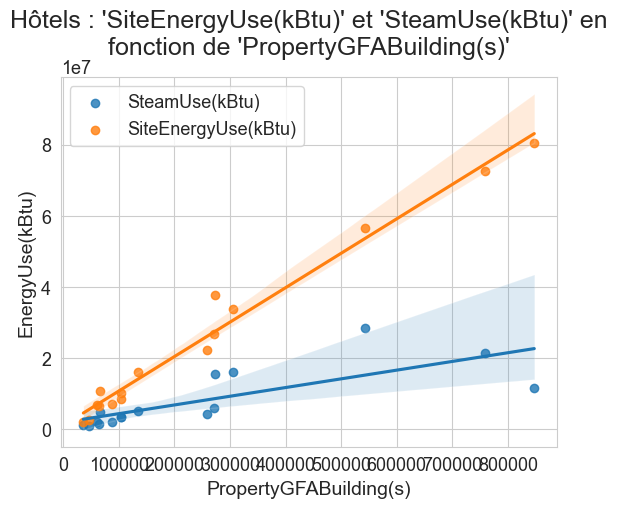

In [111]:
# Consommation totale et de vapeur pour les hôtels en fonction de la surface
fig, ax = plt.subplots(1,1)

sns.regplot(data = building_data[(building_data['PrimaryPropertyType']=='Hotel')&
                                     (building_data['SteamUse(kBtu)']!=0)],
                x = 'PropertyGFABuilding(s)',
                y = 'SteamUse(kBtu)',
                label='SteamUse(kBtu)',
                ax = ax)

sns.regplot(data = building_data[(building_data['PrimaryPropertyType']=='Hotel')&
                                     (building_data['SteamUse(kBtu)']!=0)],
                x = 'PropertyGFABuilding(s)',
                y = 'SiteEnergyUse(kBtu)',
                label='SiteEnergyUse(kBtu)',
                ax = ax)

ax.set_title("Hôtels : 'SiteEnergyUse(kBtu)' et 'SteamUse(kBtu)' en fonction de 'PropertyGFABuilding(s)'", wrap=True)
ax.set_ylabel('EnergyUse(kBtu)')
ax.legend()
plt.show()

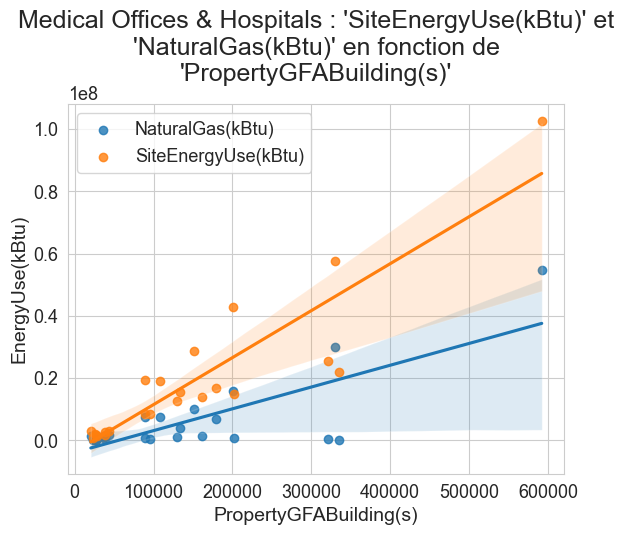

In [112]:
# Consommation totale et de gaz pour les Medical offices et les Hospitals en fonction de la surface
fig, ax = plt.subplots(1,1)

sns.regplot(data = building_data[(building_data['PrimaryPropertyType'].isin(['Medical Office', 'Hospital']))&
                                     (building_data['NaturalGas(kBtu)']!=0)],
                x = 'PropertyGFABuilding(s)',
                y = 'NaturalGas(kBtu)',
                label = 'NaturalGas(kBtu)',
                ax = ax)

sns.regplot(data = building_data[(building_data['PrimaryPropertyType'].isin(['Medical Office', 'Hospital']))&
                                     (building_data['NaturalGas(kBtu)']!=0)],
                x = 'PropertyGFABuilding(s)',
                y = 'SiteEnergyUse(kBtu)',
                label = 'SiteEnergyUse(kBtu)',
                ax = ax)

ax.set_title("Medical Offices & Hospitals : 'SiteEnergyUse(kBtu)' et 'NaturalGas(kBtu)' en fonction de 'PropertyGFABuilding(s)'", wrap=True)
ax.set_ylabel('EnergyUse(kBtu)')
ax.legend()
plt.show()

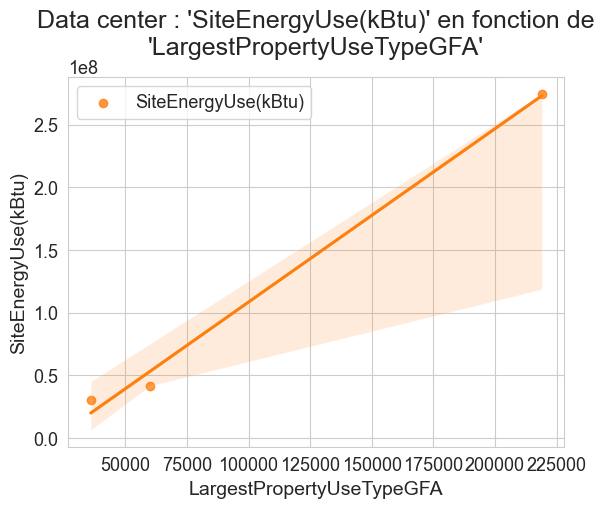

In [113]:
# Consommation totale les Data Centers en fonction de la surface
fig, ax = plt.subplots(1,1)

sns.regplot(data = building_data[(building_data['LargestPropertyUseType']=='Data Center')],
                x = 'LargestPropertyUseTypeGFA',
                y = 'SiteEnergyUse(kBtu)',
                label = 'SiteEnergyUse(kBtu)',
                color = sns.color_palette()[1],
                ax = ax)

ax.set_title("Data center : 'SiteEnergyUse(kBtu)' en fonction de 'LargestPropertyUseTypeGFA'", wrap=True)
ax.set_ylabel('SiteEnergyUse(kBtu)')
ax.legend()
plt.show()

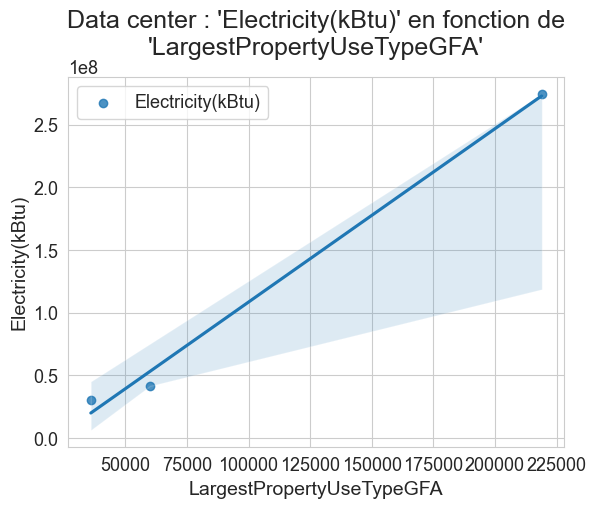

In [114]:
# Consommation d'électricité pour les Data Centers en fonction de la surface
fig, ax = plt.subplots(1,1)

sns.regplot(data = building_data[(building_data['LargestPropertyUseType']=='Data Center')],
                x = 'LargestPropertyUseTypeGFA',
                y = 'Electricity(kBtu)',
                label = 'Electricity(kBtu)',
                ax = ax)

ax.set_title("Data center : 'Electricity(kBtu)' en fonction de 'LargestPropertyUseTypeGFA'", wrap=True)
ax.set_ylabel('Electricity(kBtu)')
ax.legend()
plt.show()

Ces bâtiments ne sont en fait pas de vrais outliers : leur consommation énergétique est cohérente par rapport à leur surface et leur catégorie.

# <font color='#0a389f'>Partie 4 - Analyse exploratoire<a class="anchor" id="partie_5"></a></font>

## <font color='#46abe6'>4.1. Ajout de nouvelles variables<a class="anchor" id="4_1"></a></font>

Les données de consommations énergétiques ne seront pas disponibles dans le futur et sont, de plus, corrélées aux variables cibles. Elles ne sont pas à conserver en l'état pour la modélisation.
Le calcul du mix énergétique est lui par contre une information pertinente.

In [115]:
# Age du bâtiment ou des dernières rénovations
building_data['BuildingAge'] = 2016 - building_data['YearBuilt']

# Pourcentage de la surface totale utilisée en 'Parking'
building_data['PropertyGFAParking(%)'] = round(building_data['PropertyGFAParking']/building_data['PropertyGFATotal'],2)

# Pourcentage de la surface totale utilisée en 'Buildings'
building_data['PropertyGFABuilding(%)'] = round(building_data['PropertyGFABuilding(s)']/building_data['PropertyGFATotal'],2)

# Pourcentage d'Energie provenant de Steam
building_data['SteamUse(%)'] = round(building_data['SteamUse(kBtu)']/building_data['SiteEnergyUse(kBtu)'],2)

# Pourcentage d'Energie provenant de  Electricity
building_data['ElectricityUse(%)'] = round(building_data['Electricity(kBtu)']/building_data['SiteEnergyUse(kBtu)'],2)

# Pourcentage d'Energie provenant de  Natural Gas
building_data['NaturalGasUse(%)'] = round(building_data['NaturalGas(kBtu)']/building_data['SiteEnergyUse(kBtu)'],2)

In [116]:
# Ajoute la modification au change_log
new_features = ['BuildingAge',
                'PropertyGFAParking(%)',
                'PropertyGFABuilding(%)',
                'SteamUse(%)',
                'ElectricityUse(%)',
                'NaturalGasUse(%)'
               ]
change_log(change_log_df, 
           building_data, 
           ['Ajout de variables', 
            new_features, 
            'Nouvelles variables en pourcentage'] 
           )

In [117]:
round(building_data[new_features].describe(),2)

BuildingAge  PropertyGFAParking(%)  PropertyGFABuilding(%)  \
count       1324.0                1324.00                 1324.00   
mean          55.1                   0.07                    0.93   
std           32.9                   0.15                    0.15   
min            1.0                   0.00                    0.20   
25%           28.0                   0.00                    1.00   
50%           51.0                   0.00                    1.00   
75%           87.0                   0.00                    1.00   
max          116.0                   0.80                    1.00   

       SteamUse(%)  ElectricityUse(%)  NaturalGasUse(%)  
count      1324.00            1324.00           1324.00  
mean          0.02               0.71              0.27  
std           0.09               0.26              0.26  
min           0.00               0.00              0.00  
25%           0.00               0.49              0.00  
50%           0.00               0.73              0.22  
75%           0.00               1.00              0.48  
max           0.77               1.00              1.00

## <font color='#46abe6'>4.2. Distribution des variables<a class="anchor" id="4_2"></a></font>

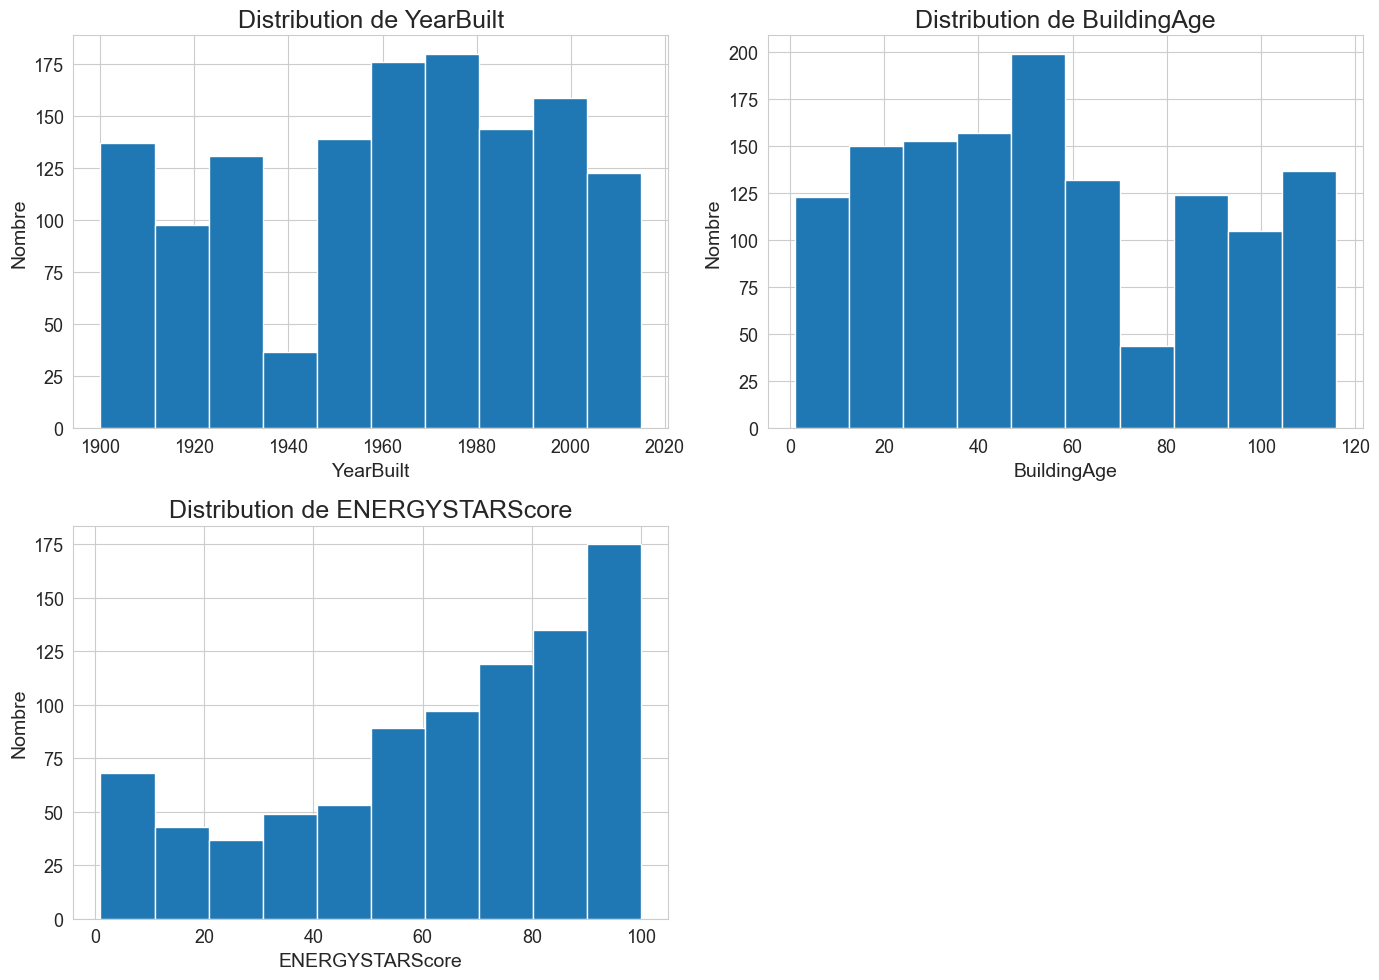

In [118]:
# Distribution des variables - Histogramme
hist_col = [ 'YearBuilt',
            'BuildingAge',
             'ENERGYSTARScore']

nb_cols = 2
nb_plots = len(hist_col)
nb_rows = nb_plots//nb_cols + nb_plots%nb_cols
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(width* nb_cols, height* nb_rows), squeeze=False)

# Boucle pour créer et afficher les graphiques
for i, ind in enumerate(hist_col):
    row = i // nb_cols
    col = i % nb_cols
    ax = axs[row, col]
    ax.hist(building_data[ind])
    ax.set_title("Distribution de "+ind, wrap=True)
    ax.set_xlabel(ind)
    ax.set_ylabel('Nombre') 
     
    # Masquer les graphiques vides (s'il y en a)
    for i in range(nb_plots, nb_rows * nb_cols):
        axs[i // nb_cols, i % nb_cols].axis('off')
    
fig.tight_layout()
plt.show()

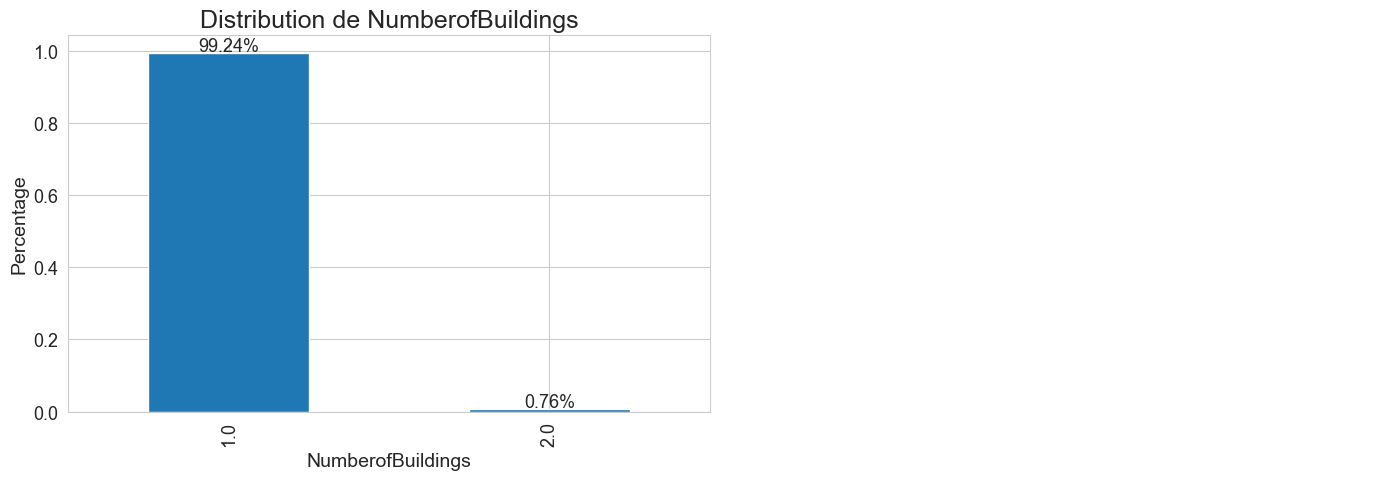

In [119]:
# Distribution des variables - bar plot
bar_col = [ 'NumberofBuildings']

nb_cols = 2
nb_plots = len(bar_col)
nb_rows = nb_plots//nb_cols + nb_plots%nb_cols
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(width* nb_cols, height* nb_rows), squeeze=False)

# Boucle pour créer et afficher les graphiques
for i, ind in enumerate(bar_col):
    row = i // nb_cols
    col = i % nb_cols
    ax = axs[row, col]
    building_data[ind].value_counts(normalize=True).plot(kind='bar', ax=ax)
    ax.set_title("Distribution de "+ind, wrap=True)
    ax.set_xlabel(ind)
    ax.set_ylabel('Percentage') 
    
    # Annotation des barres
    for p in ax.patches:
        ax.annotate(f'{p.get_height() * 100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
     
     
    # Masquer les graphiques vides (s'il y en a)
    for i in range(nb_plots, nb_rows * nb_cols):
        axs[i // nb_cols, i % nb_cols].axis('off')
    
fig.tight_layout()
plt.show()

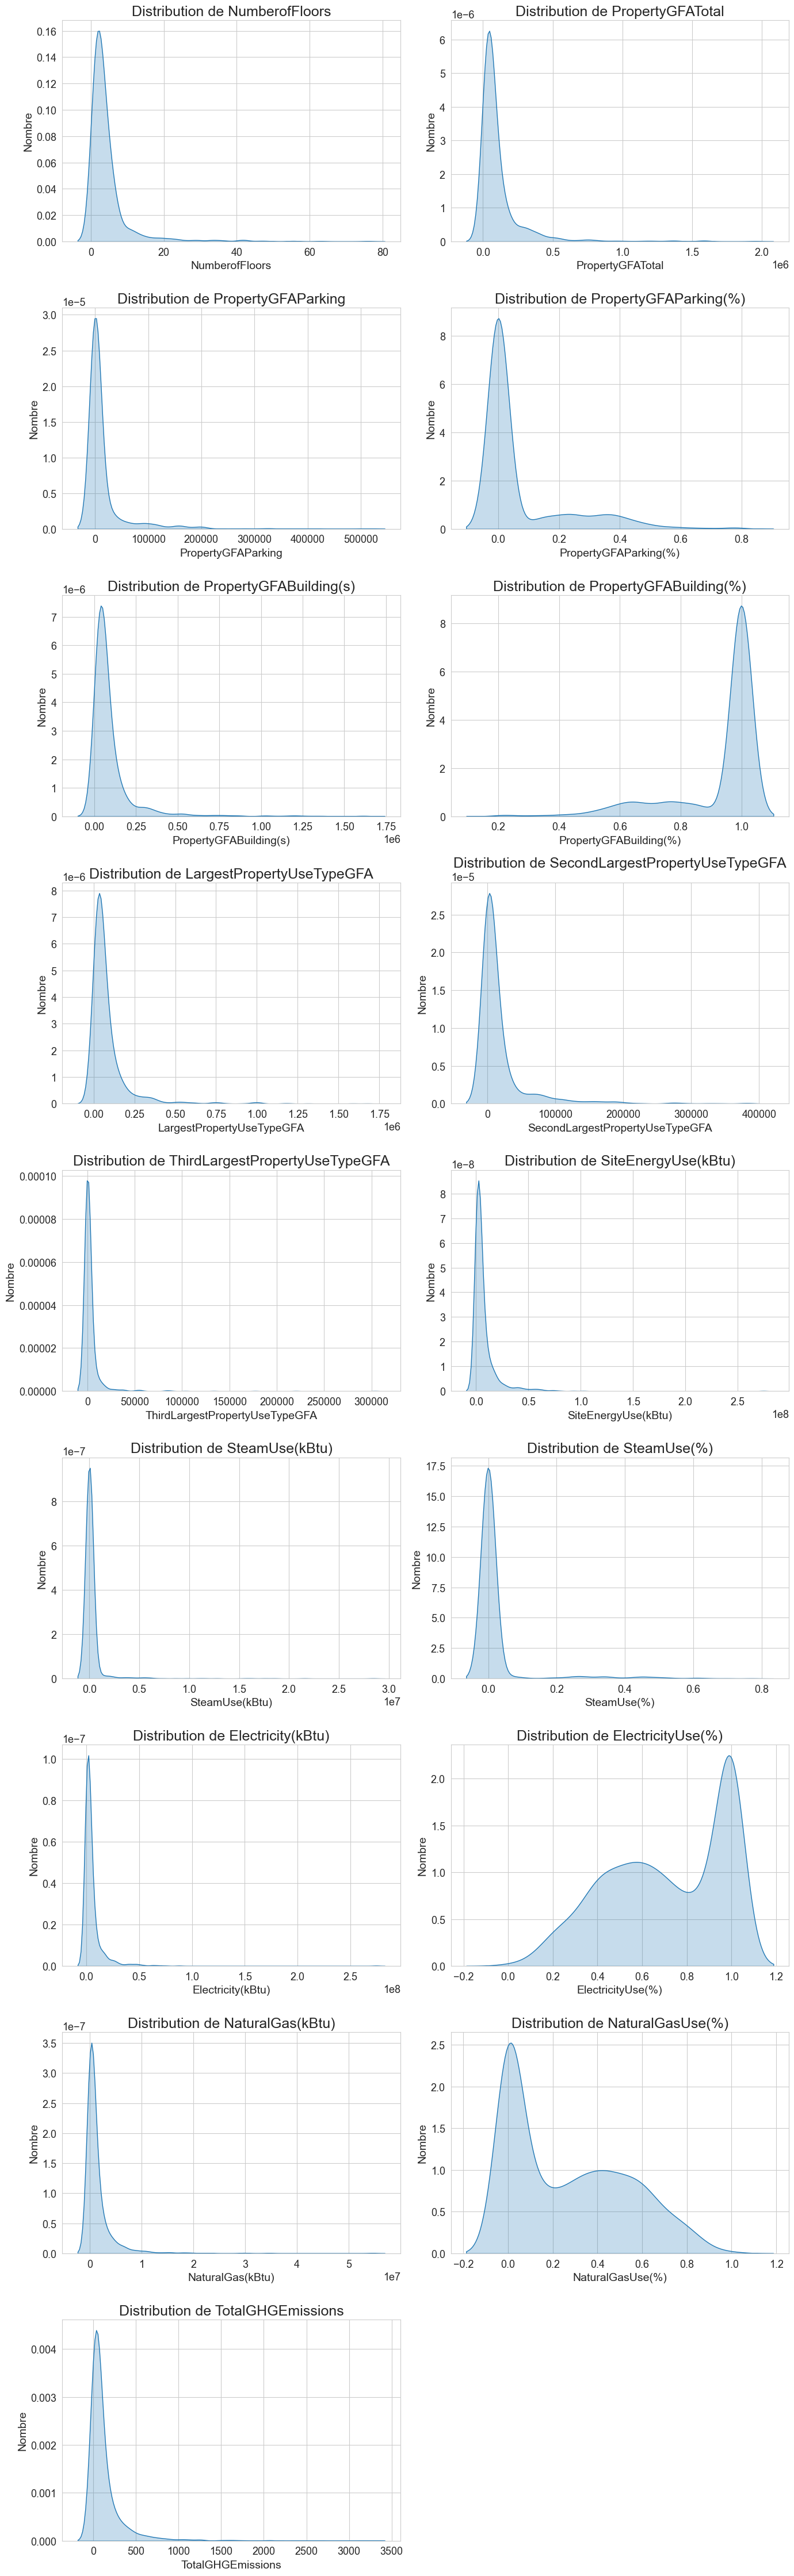

In [120]:
# Distribution des variables - Density
kde_col =   ['NumberofFloors', 
             'PropertyGFATotal',
             'PropertyGFAParking',
             'PropertyGFAParking(%)',
             'PropertyGFABuilding(s)',
             'PropertyGFABuilding(%)',
             'LargestPropertyUseTypeGFA',
             'SecondLargestPropertyUseTypeGFA',
             'ThirdLargestPropertyUseTypeGFA',
             'SiteEnergyUse(kBtu)',
             'SteamUse(kBtu)',
             'SteamUse(%)',
             'Electricity(kBtu)',
             'ElectricityUse(%)',
             'NaturalGas(kBtu)',
             'NaturalGasUse(%)',
             'TotalGHGEmissions']

nb_cols = 2
nb_plots = len(kde_col)
nb_rows = nb_plots//nb_cols + nb_plots%nb_cols
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(width* nb_cols, height* nb_rows), squeeze=False)

# Boucle pour créer et afficher les graphiques
for i, ind in enumerate(kde_col):
    row = i // nb_cols
    col = i % nb_cols
    ax = axs[row, col]
    sns.kdeplot(building_data[ind], fill=True, ax=ax)
    ax.set_title("Distribution de "+ind, wrap=True)
    ax.set_xlabel(ind)
    ax.set_ylabel('Nombre') 
     
    # Masquer les graphiques vides (s'il y en a)
    for i in range(nb_plots, nb_rows * nb_cols):
        axs[i // nb_cols, i % nb_cols].axis('off')
    
fig.tight_layout()
plt.show()

- Les majeures parties des distributions sont désaxées vers la droite, longue queue à droite.
- 'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)','TotalGHGEmissions' : toutes le valeurs sont >0 : Une transformation de type log pourrait permettre de normaliser la distribution.
- 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA' : valeurs = 0, une transformation de type racine carrée pourrait permettre de normaliser la distribution.

## <font color='#46abe6'>4.3. Transformation possibles des variables pour normalisation<a class="anchor" id="4_3"></a></font>

- **Transformation logarithmique**

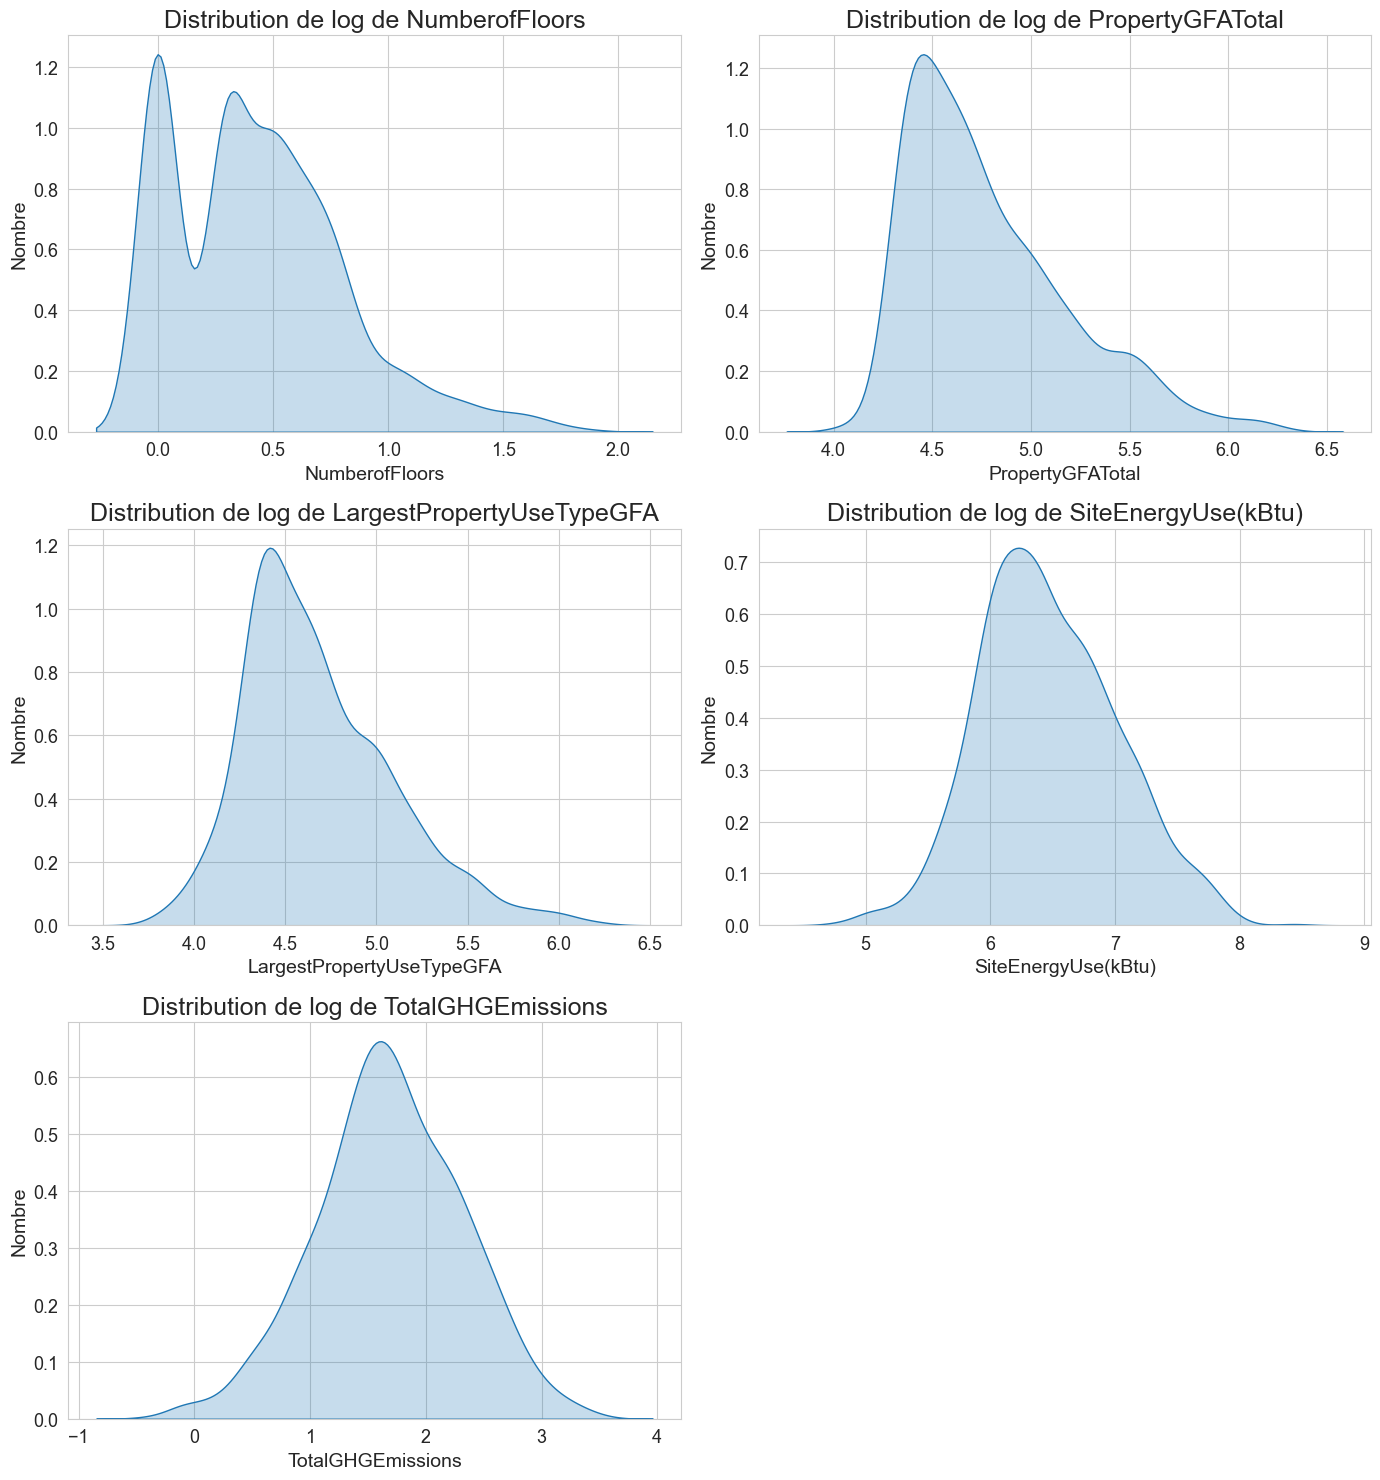

In [121]:
# Distribution des variables - Density
log_col =   ['NumberofFloors',
             'PropertyGFATotal',
             'LargestPropertyUseTypeGFA',
             'SiteEnergyUse(kBtu)',
             'TotalGHGEmissions']

nb_cols = 2
nb_plots = len(log_col)
nb_rows = nb_plots//nb_cols + nb_plots%nb_cols
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(width* nb_cols, height* nb_rows), squeeze=False)

# Boucle pour créer et afficher les graphiques
for i, ind in enumerate(log_col):
    row = i // nb_cols
    col = i % nb_cols
    ax = axs[row, col]
    sns.kdeplot(np.log10(building_data[ind]), fill=True, ax=ax)
    ax.set_title("Distribution de log de "+ind, wrap=True)
    ax.set_xlabel(ind)
    ax.set_ylabel('Nombre') 
     
    # Masquer les graphiques vides (s'il y en a)
    for i in range(nb_plots, nb_rows * nb_cols):
        axs[i // nb_cols, i % nb_cols].axis('off')
    
fig.tight_layout()
plt.show()

- **Transformation par racine carrée**

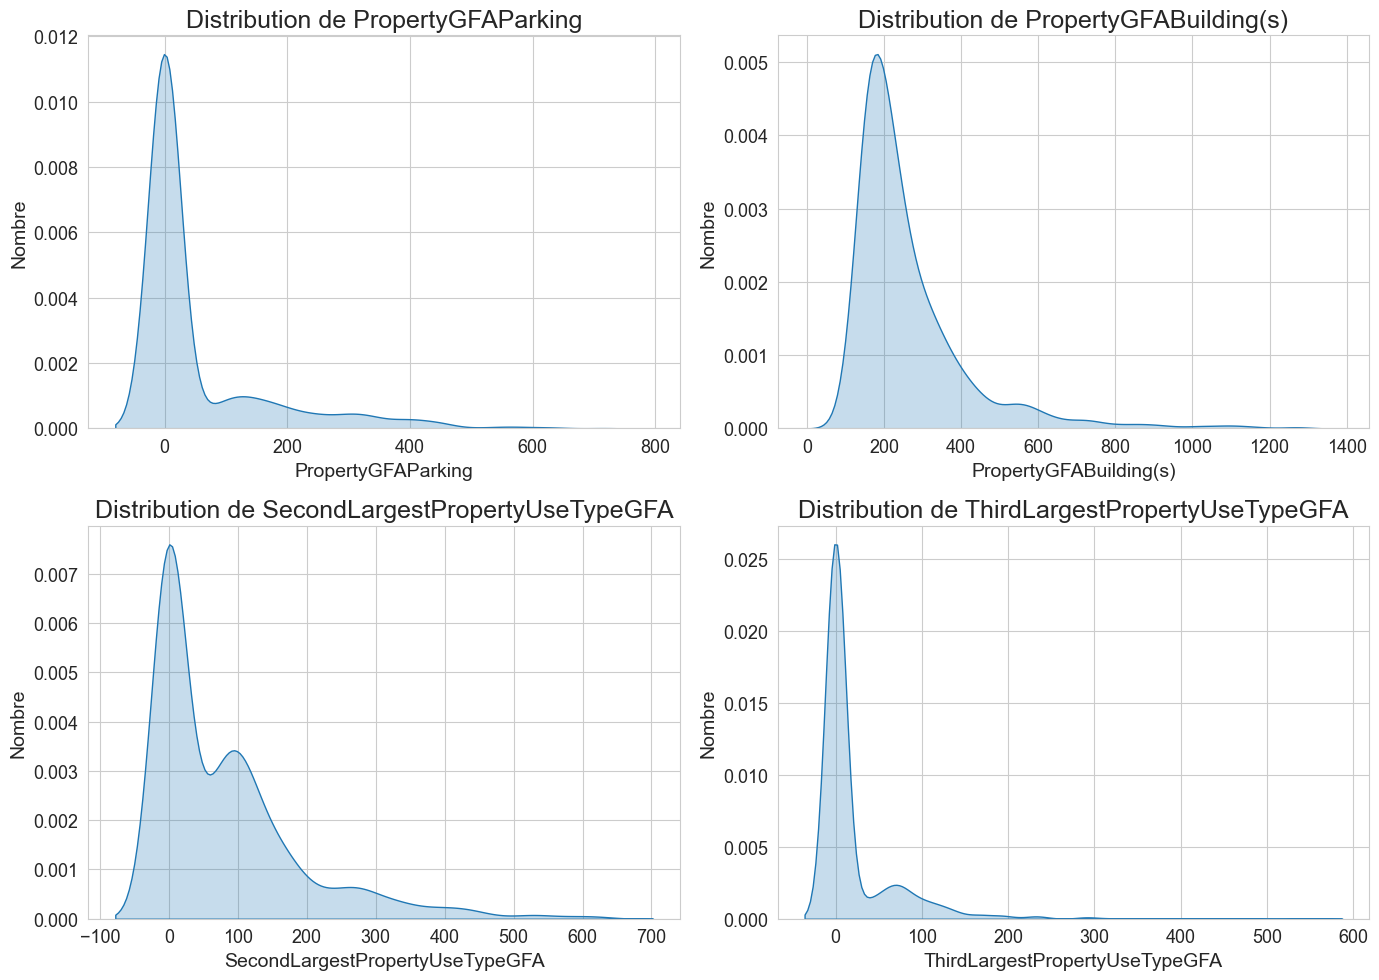

In [122]:
# Distribution des variables - Density
squareroot_col =    ['PropertyGFAParking',
                     'PropertyGFABuilding(s)',
                     'SecondLargestPropertyUseTypeGFA',
                     'ThirdLargestPropertyUseTypeGFA']

col = squareroot_col
nb_cols = 2
nb_plots = len(col)
nb_rows = nb_plots//nb_cols + nb_plots%nb_cols
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(width* nb_cols, height* nb_rows), squeeze=False)

# Boucle pour créer et afficher les graphiques
for i, ind in enumerate(col):
    row = i // nb_cols
    col = i % nb_cols
    ax = axs[row, col]
    sns.kdeplot(np.sqrt(building_data[ind]), fill=True, ax=ax)
    ax.set_title("Distribution de "+ind, wrap=True)
    ax.set_xlabel(ind)
    ax.set_ylabel('Nombre') 
     
    # Masquer les graphiques vides (s'il y en a)
    for i in range(nb_plots, nb_rows * nb_cols):
        axs[i // nb_cols, i % nb_cols].axis('off')
    
fig.tight_layout()
plt.show()

## <font color='#46abe6'>4.4. Distribution par 'Neighborhood' et par 'PrimaryPropertyType'<a class="anchor" id="4_4"></a></font>

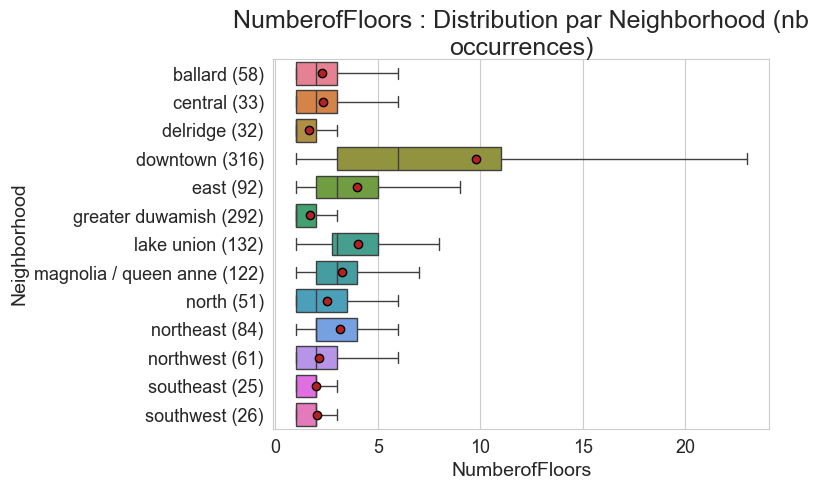

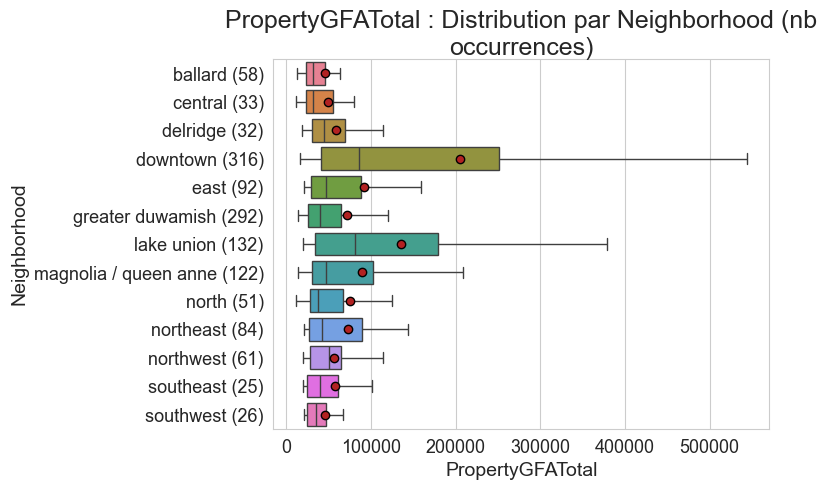

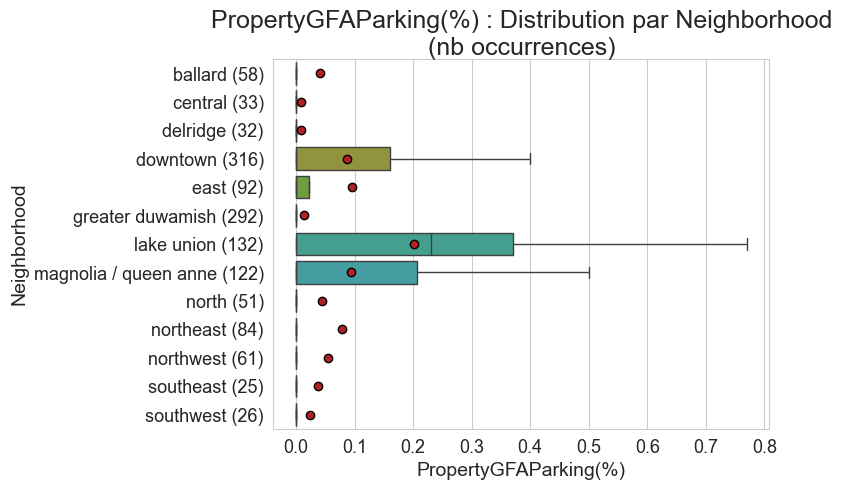

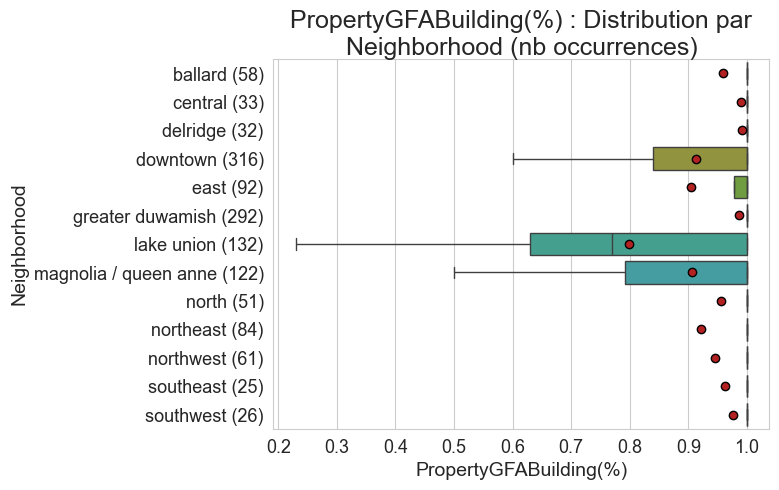

In [123]:
# Distribution des variables énergies par type 'PrimaryPropertyType'
building_var = ['NumberofFloors',
                'PropertyGFATotal',
                'PropertyGFAParking(%)', 
                'PropertyGFABuilding(%)']
stats(building_data, building_var, 'Neighborhood', None, False)

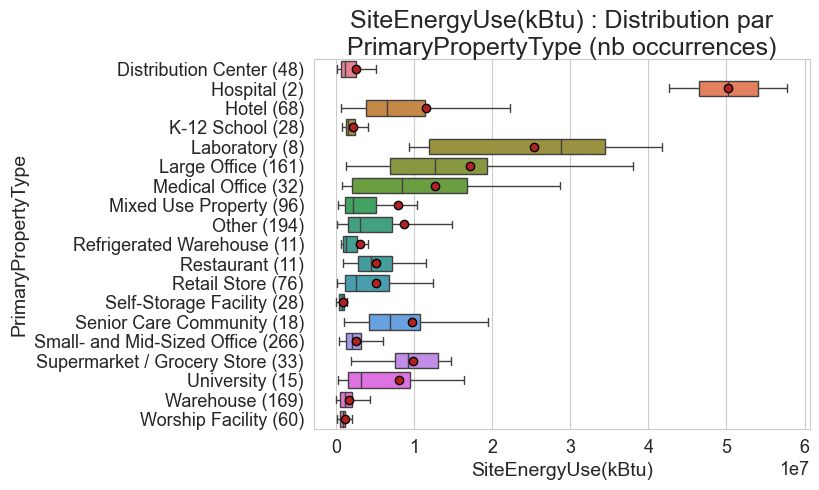

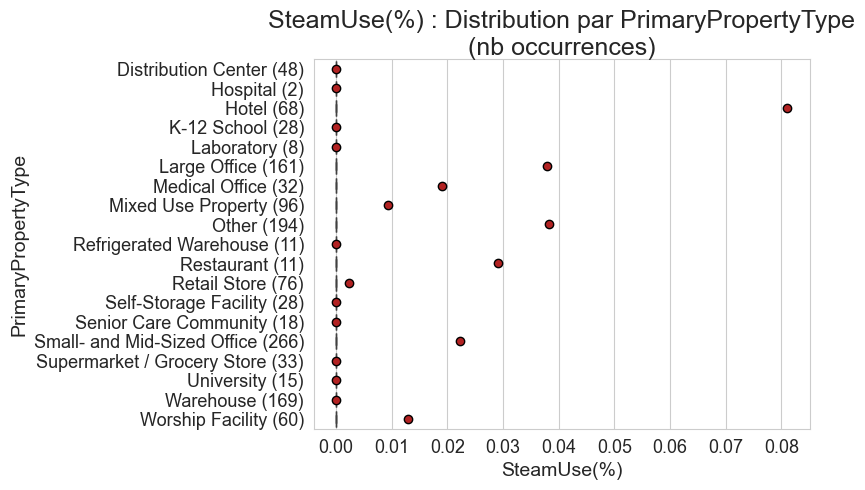

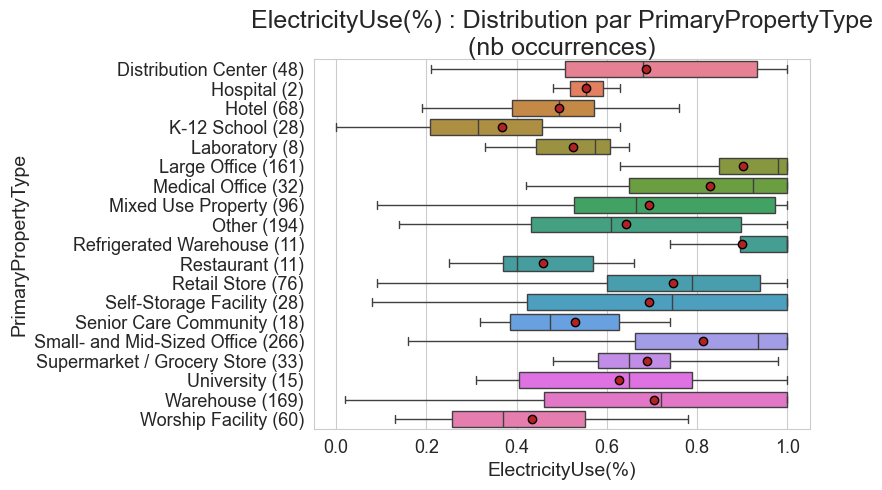

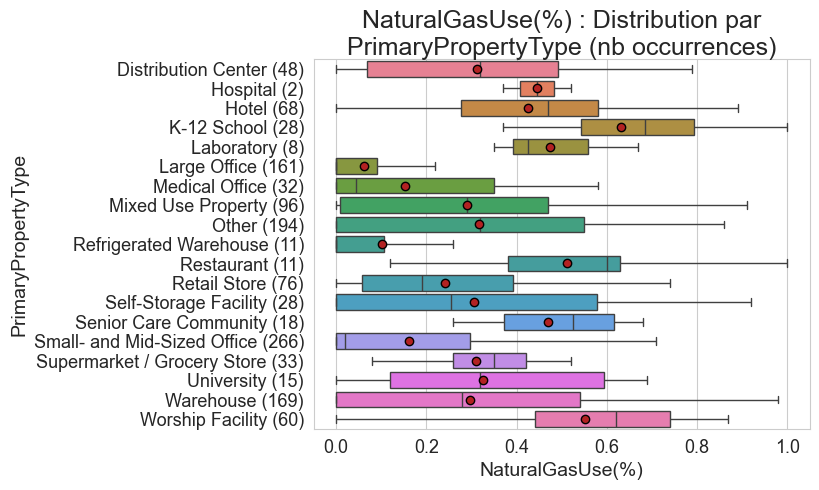

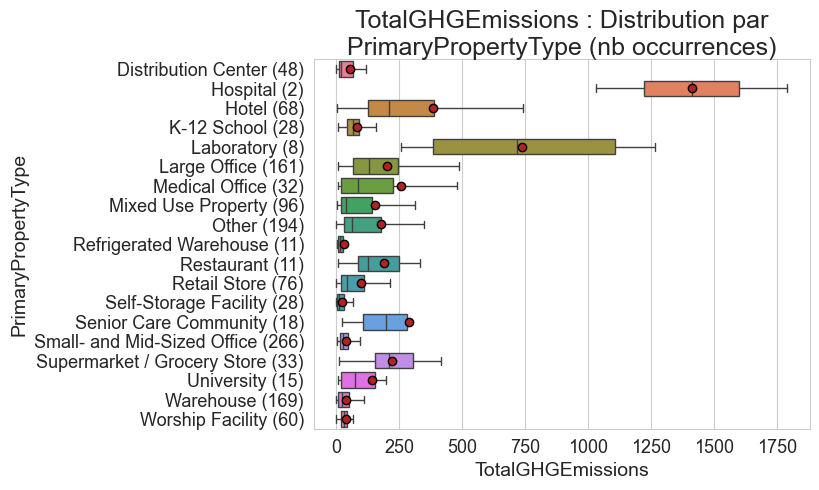

In [124]:
# Distribution des variables énergies par type 'PrimaryPropertyType'
nrj_var = [ 'SiteEnergyUse(kBtu)', 'SteamUse(%)', 'ElectricityUse(%)', 'NaturalGasUse(%)', 'TotalGHGEmissions']
stats(building_data, nrj_var, 'PrimaryPropertyType', None, False)

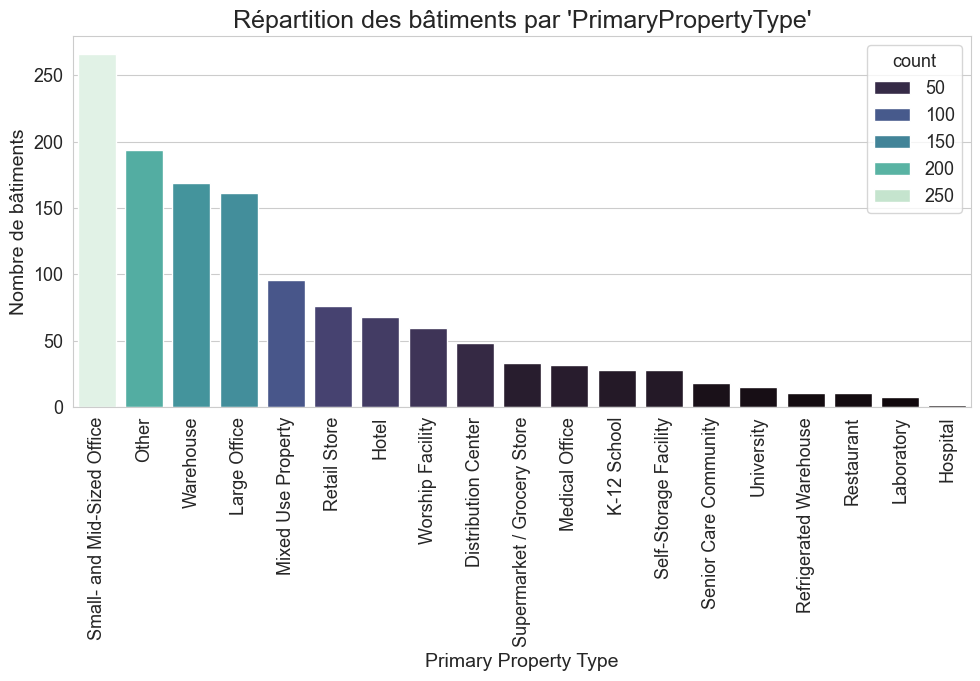

In [125]:
# Répartition des bâtiments par 'PrimaryPropertyType'
plt.figure(figsize=(10, 7))

sns.barplot(x=building_data['PrimaryPropertyType'].value_counts().index,
            y=building_data['PrimaryPropertyType'].value_counts(),
            hue=building_data['PrimaryPropertyType'].value_counts(),
            palette='mako')

plt.title("Répartition des bâtiments par 'PrimaryPropertyType'")
plt.xlabel('Primary Property Type')
plt.xticks(rotation=90)
plt.ylabel('Nombre de bâtiments')

plt.tight_layout()
plt.show()

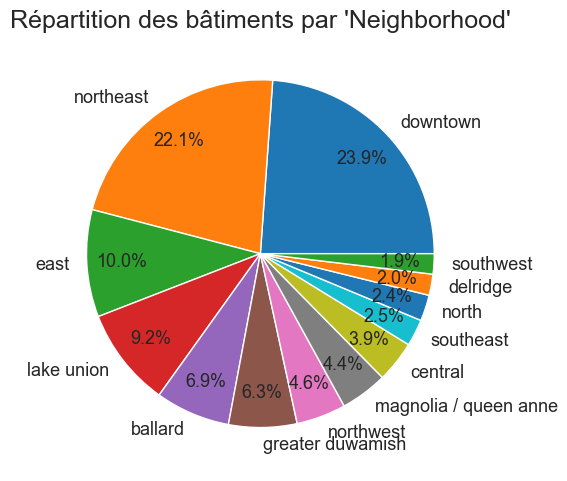

In [126]:
# Répartition des bâtiments par 'Neighborhood'
fig, ax = plt.subplots(1,1,figsize=(10,5))
 
ax.pie(x=building_data['Neighborhood'].value_counts(),                                   
       labels = list(building_data['Neighborhood'].unique()),
       autopct='%.1f%%',
       pctdistance=0.8)
ax.set_title("Répartition des bâtiments par 'Neighborhood'")

plt.tight_layout()
plt.show()

## <font color='#46abe6'>4.5. Corrélation entre les variables<a class="anchor" id="4_5"></a></font>

In [130]:
final_selection = [  'BuildingAge',
                     'NumberofBuildings', 
                     'NumberofFloors',
                     'PropertyGFATotal', 
                     'PropertyGFAParking(%)', 
                     'PropertyGFABuilding(%)',
                     'ENERGYSTARScore',
                     'SteamUse(%)',
                     'ElectricityUse(%)', 
                     'NaturalGasUse(%)',
                     'SiteEnergyUse(kBtu)', 
                     'TotalGHGEmissions']

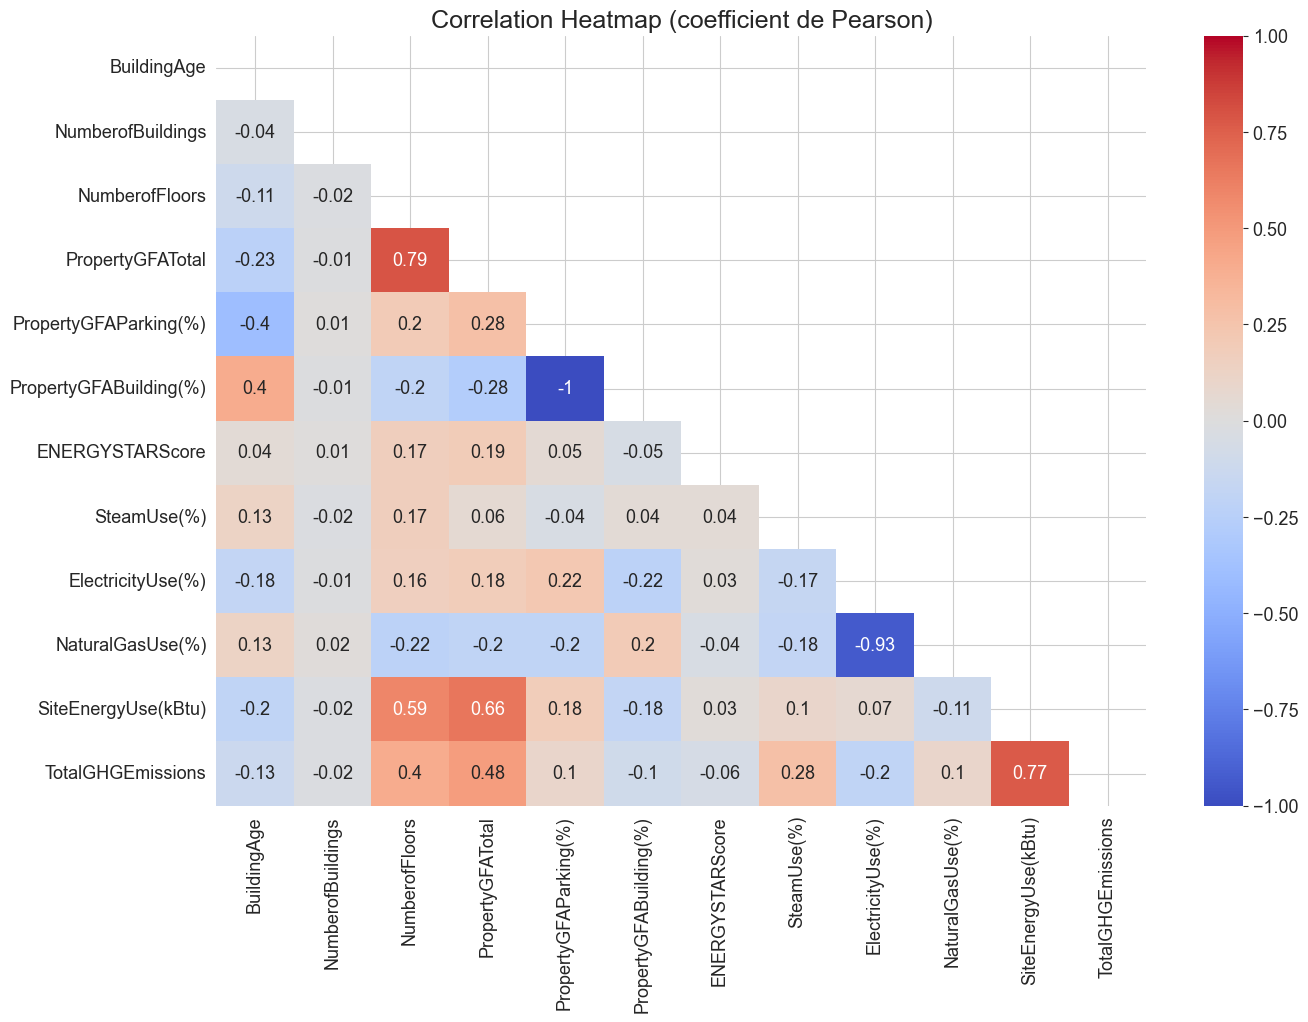

In [131]:
# Calcul du coefficient de corrélation de Pearson et représentation sous forme de heatmap
plt.figure(figsize=(15,10))
corr = round(building_data[final_selection].corr(method='pearson'),2)
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='coolwarm', 
                      mask=mask)
heatmap.set_title('Correlation Heatmap (coefficient de Pearson)')
plt.show()

In [128]:
# Suppression des variables non retenues
to_drop =  ['PropertyName', 
            'Address',
            'YearBuilt',
            'PropertyGFAParking', 
            'PropertyGFABuilding(s)',
            'ListOfAllPropertyUseTypes', 
            'LargestPropertyUseType', 
            'LargestPropertyUseTypeGFA',
            'SecondLargestPropertyUseType', 
            'SecondLargestPropertyUseTypeGFA',
            'ThirdLargestPropertyUseType', 
            'ThirdLargestPropertyUseTypeGFA',
            'SteamUse(kBtu)', 
            'Electricity(kBtu)', 
            'NaturalGas(kBtu)']

building_data = building_data.drop(to_drop, axis=1)

In [129]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           building_data, 
           ['Supression de variables', 
            to_drop, 
            'Variables non retenues pour la modélisation'] 
           )

## <font color='#46abe6'>4.6. Sauvegarde des datasets pour la modélisation<a class="anchor" id="4_6"></a></font>

In [130]:
data_energystarscore = building_data[building_data['ENERGYSTARScore'].notna()]
print(data_energystarscore.shape)
data_energystarscore.to_pickle('data_ENERGYSTARScore.pkl')

(865, 15)


In [131]:
data = building_data.drop('ENERGYSTARScore', axis=1)
print(data.shape)
data.to_pickle('data_afterEDA.pkl')

(1324, 14)


## <font color='#46abe6'>4.7 Change log<a class="anchor" id="4_7"></a></font>

In [132]:
display(change_log_df)

nb_rows  nb_columns               change_type  \
0      3376          42              Etat initial   
1      1546          41     Filtre et suppression   
2      1514          38     Filtre et suppression   
3      1514          37  Suppression de variables   
4      1514          32  Suppression de variables   
5      1514          31  Suppression de variables   
6      1514          29  Suppression de variables   
7      1514          28  Suppression de variables   
8      1514          27  Suppression de variables   
9      1514          24  Suppression de variables   
10     1492          24                    Filtre   
11     1476          24                    Filtre   
12     1453          24                    Filtre   
13     1444          24        Valeurs aberrantes   
14     1326          24        Valeurs aberrantes   
15     1324          24        Valeurs aberrantes   
16     1324          30        Ajout de variables   
17     1324          15   Supression de variables   

                                                   on  \
0                                                   -   
1                                        BuildingType   
2      ['ComplianceStatus', 'DefaultData', 'Outlier']   
3                               GHGEmissionsIntensity   
4   [SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceE...   
5     ['ENERGYSTARScore', 'YearsENERGYSTARCertified']   
6              [Electricity(kWh), NaturalGas(therms)]   
7                                             ZipCode   
8                       TaxParcelIdentificationNumber   
9          [CouncilDistrictCode, Latitude, Longitude]   
10                                PrimaryPropertyType   
11                             LargestPropertyUseType   
12                                  NumberofBuildings   
13                                     NumberofFloors   
14                          LargestPropertyUseTypeGFA   
15                                  Electricity(kBtu)   
16  [BuildingAge, PropertyGFAParking(%), PropertyG...   
17  [PropertyName, Address, YearBuilt, PropertyGFA...   

                                          description  
0                           Etat initial du dataframe  
1   Cible = Bâtiments non destinés à l’habitation ...  
2                      ComplianceStatus = 'Compliant'  
3   Variable corrélée à la variable cible 'TotalGH...  
4   Variables corrélées à la variable cible 'SiteE...  
5                Beaucoup de valeurs manquantes > 94%  
6   Choix de l'unité kBtu pour les variables énergies  
7                                Variable non retenue  
8                                Variable non retenue  
9                              Variables non retenues  
10  Exclure 'Low-Rise Multifamily', 'Residence Hal...  
11  Exclure les bâtiments dont l'usage est majorit...  
12                             'NumberofBuildings'<=2  
13                       Retenus : 0<'NumberofFloors'  
14  'PropertyGFATotal'*1.02>='LargestPropertyUseTy...  
15   'Electricity(kBtu)'>=0 et 'TotalGHGEmissions'>=0  
16                 Nouvelles variables en pourcentage  
17        Variables non retenues pour la modélisation

# <font color='#0a389f'>Conclusion & Perspectives<a class="anchor" id="partie_6"></a></font>

**Conclusion**

* Les variables retenues sont les suivantes :
    - Targets : 'SiteEnergyUse(kBtu)' et 'TotalGHGEmissions'
    - Variables initiales retenues : 'PrimaryPropertyType', 'Neighborhood','NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal','ENERGYSTARScore'
    - Nouvelles variables : 'BuildingAge', 'PropertyGFAParking(%)', 'PropertyGFABuilding(%)','SteamUse(%)',  'ElectricityUse(%)', 'NaturalGasUse(%)'

* Les propriétés concernées pour les modèles de prédiction seront celles avec 1 ou 2 bâtiments.

* Transformations des variables pour normalisation : une transformation logarithmique pourra être utilisée pour normaliser les distributions de 'PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'SiteEnergyUse(kBtu)' et 'TotalGHGEmissions'



**Perspectives :**
- Features engineering :
    - utilisation de LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType : % d'utilisation de chaque property use
- Informations complémentaires sur le bâtiment : 
    - mitoyen ou non : cela peut limiter les déperditions énergétiques
    - isolation thermique, bâtiments Haute Qualité Energétique ou non
    - type de système de chauffage / climatisation 
    - toiture végétalisée ou non
    - proximité de l'eau ou des parcs